In [5]:
import numpy as np
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/jfm.mplstyle')
import pandas as pd
from matplotlib.legend_handler import HandlerTuple
from IPython.core.display import HTML

from coordinate import array_newcoord
from scipy.signal import savgol_filter

## Summary:
This notebook detects breaking fronts, maps them to velocity field, and computes breaker statistics.
## <a class="anchor" id="0">Table of content: </a> 

#### [1. Compute stats: process presssure, compute Fp, setting windows](#1)
#### [2. Visulization of time evolution](#2)
#### [3. Updated plots of Fp and Sin](#3)
#### [4. Breaking case (ak=0.3)](#4)

### Stats with the old cases (use kernel of ReadIn_new.ipynb)

In [8]:
""" PROCESSING: Process the bulk pressure field case.p_2D (time series) and compute the enery input. 
    Dependency: array_newcoord function. Need case.p_2D arrays.
    Add Fp to the case. """

def processing_energy1 (case):
    case.Fp = np.zeros(len(case.p['p_2D']))
    case.p_1D = np.zeros((len(case.p['p_2D']), 512))
    case.grad = np.zeros((len(case.p['p_2D']), 512))
    for i in tqdm(range(0, len(case.p['p_2D']))):
        # Find time of eta and f
        etai = np.where(np.isclose(case.phase['t'], case.p['t'][i]))[0][0]
        f_2D = case.f_2D[-1]
#         fieldi = np.where(np.isclose(case.field_t, case.p['t'][i]))[0][0]
#         f_2D = case.f_2D[fieldi] # We don't have as big a smapling frequency for f_2D
        """ Subtract the mean """
        case.p['p_2D'][i] = case.p['p_2D'][i]*(1-f_2D)**10 # Air velocity
        paverage = np.average(case.p['p_2D'][i][:,90:512])
        case.p['p_2D'][i] = (case.p['p_2D'][i] - paverage)*(1-f_2D)**10
        """ Interpolate onto new coordinate """
        eta = np.roll(np.average(case.phase['eta'][etai], axis=0), -case.phase['idx'][etai], axis=0) - 1
        p_2D_interp, zgrid = array_newcoord(case.p['p_2D'][i], case=case, eta=eta)
        """ Smooth eta and compute the gradient """
        etahat = savgol_filter(eta, 31, 4) # window size 51, polynomial order 3
        grad = np.gradient(etahat)/(2*np.pi/512)   
#         theta = np.linspace(0,8*np.pi,512)
#         grad = -np.sin(theta)*case.k*(np.var(eta)*2)**0.5
        """ Compute the energy input """
        p = p_2D_interp[:,88] - np.average(p_2D_interp[:,88])
        case.p_1D[i] = p
        case.grad[i] = grad
        case.Fp[i] = np.average(p*grad)

# for case in (case1,case2,case3,case4,case5,case6,case7,case8,case9,case10,case11,case12,case13,case14,case15,case16):
#     processing_energy1(case)
    
# for case in (case17,case18,case19):
#     processing_energy1(case)

# for case in (case_rerun1,case_rerun2,case_rerun3,case_rerun4,case_rerun5,case_rerun6):
#     processing_energy1(case)

100%|██████████| 69/69 [00:43<00:00,  1.58it/s]


In [9]:
""" Collect Fp samples with different treatment because of sampling rate 
    case.Fp_aver to be compatible with the old code
    case.Fp_stat for the new window averaging
"""
    
for case in (case1,case2,case3,case4,case5,case6,case7,case9,case11,case17,case18):
    variance = [np.var(eta) for eta in case.phase['eta']] 
    pp = [(eta.max()-eta.min())/2. for eta in case.phase['eta']]  
    case.Fp_aver = np.average(case.Fp[2:])
    case.arms_aver = np.average(variance)**0.5*1.41
    # Single value stats
#     case.Fp_stat = {"Fp_mean":np.average(case.Fp[2:]), "Fp_max":case.Fp[2:].max(), "Fp_min":case.Fp[2:].min(), "Fp_std":np.std(case.Fp[2:])
#                     'arms_mean':np.average(variance)**0.5*1.41, 'arms_max':np.array(variance).max()**0.5*1.41, 'arms_min':np.array(variance).min()**0.5*1.41,
#                     'app_mean':np.average(pp), 'app_max':np.array(pp).max(), 'app_min':np.array(pp).min()}
    case.Fp_stat = {"Fp_mean":np.average(case.Fp[2:]), "Fp_std":np.std(case.Fp[2:]),
                    'arms_mean':np.average(variance)**0.5*1.41, 'arms_max':np.array(variance).max()**0.5*1.41, 'arms_min':np.array(variance).min()**0.5*1.41,
                    'app_mean':np.average(pp), 'app_max':np.array(pp).max(), 'app_min':np.array(pp).min()}

for case in (case_rerun1,case_rerun2,case_rerun3,case_rerun4,case_rerun5,case_rerun6):
    variance = [np.var(eta) for eta in case.phase['eta']] 
    pp = [(eta.max()-eta.min())/2. for eta in case.phase['eta']]  
    case.Fp_aver = np.average(case.Fp[10:])
    case.arms_aver = np.average(variance)**0.5*1.41
    case.Fp_stat = {"Fp_mean":np.average(case.Fp[10:]), "Fp_std":np.std(case.Fp[10:]),
                    'arms_mean':np.average(variance)**0.5*1.41, 'arms_max':np.array(variance).max()**0.5*1.41, 'arms_min':np.array(variance).min()**0.5*1.41,
                    'app_mean':np.average(pp), 'app_max':np.array(pp).max(), 'app_min':np.array(pp).min()}
    
for case in (case8,case10,case12,case13,case14,case15,case16,case19):
    variance = [np.var(eta) for eta in case.phase['eta']] 
    pp = [(eta.max()-eta.min())/2. for eta in case.phase['eta']]  
    # Single value stats
    case.Fp_aver = np.average(case.Fp[10:])
    case.arms_aver = np.average(variance)**0.5*1.41
    case.Fp_stat = {"Fp_mean":np.average(case.Fp[10:]), "Fp_std":np.std(case.Fp[10:]),
                    'arms_mean':np.average(variance)**0.5*1.41, 'arms_max':np.array(variance).max()**0.5*1.41, 'arms_min':np.array(variance).min()**0.5*1.41,
                    'app_mean':np.average(pp), 'app_max':np.array(pp).max(), 'app_min':np.array(pp).min()}

""" 2 windows for CU=2 ak = 0.1,0.25 """
for case in (case4,case14):
    mid_index = int(len(case.phase['eta'])/2.)
    print('Cut eta from %g' %mid_index)
    variance1 = [np.var(eta) for eta in case.phase['eta'][2:mid_index]] 
    pp1 = [(eta.max()-eta.min())/2. for eta in case.phase['eta'][2:mid_index]]  
    variance2 = [np.var(eta) for eta in case.phase['eta'][mid_index:-1]] 
    pp2 = [(eta.max()-eta.min())/2. for eta in case.phase['eta'][mid_index:-1]]  
    mid_index_Fp = int(len(case.Fp)/2.)
    print('Cut Fp from %g' %mid_index_Fp)
    case.Fp_aver = np.average(case.Fp[2:mid_index_Fp])
    case.arms_aver = np.average(variance1)**0.5*1.41
    # Single value stats
    case.Fp_stat = {"Fp_mean":[np.average(case.Fp[2:mid_index_Fp]),np.average(case.Fp[mid_index_Fp:-1])], "Fp_std":[np.std(case.Fp[2:mid_index_Fp]),np.std(case.Fp[mid_index_Fp:-1])],
                    'arms_mean':[np.average(variance1)**0.5*1.41, np.average(variance2)**0.5*1.41], 'arms_max':[np.array(variance1).max()**0.5*1.41,np.array(variance2).max()**0.5*1.41], 
                    'arms_min':[np.array(variance1).min()**0.5*1.41,np.array(variance2).min()**0.5*1.41],
                    'app_mean':[np.average(pp1),np.average(pp2)], 'app_max':[np.array(pp1).max(),np.array(pp2).max()], 'app_min':[np.array(pp1).min(),np.array(pp2).min()]}

""" 3 windows for CU=2 ak = 0.15, 0.25 """
case = case7
mid_index1 = int(len(case.phase['eta'])/3.)
mid_index2 = int(len(case.phase['eta'])/3.*2.)
print('ak = %g, Cut eta from %g %g ' %(case.ak,mid_index1,mid_index2))
variance1 = [np.var(eta) for eta in case.phase['eta'][2:mid_index1]] 
pp1 = [(eta.max()-eta.min())/2. for eta in case.phase['eta'][2:mid_index1]]  
variance2 = [np.var(eta) for eta in case.phase['eta'][mid_index1:mid_index2]] 
pp2 = [(eta.max()-eta.min())/2. for eta in case.phase['eta'][mid_index1:mid_index2]]  
variance3 = [np.var(eta) for eta in case.phase['eta'][mid_index2:-1]] 
pp3 = [(eta.max()-eta.min())/2. for eta in case.phase['eta'][mid_index2:-1]]  
mid_index_Fp1 = int(len(case.Fp)/3.)
mid_index_Fp2 = int(len(case.Fp)/3.*2.)
print('ak = %g, Cut Fp from %g %g ' %(case.ak,mid_index_Fp1,mid_index_Fp2))
case.Fp_aver = np.average(case.Fp[2:mid_index_Fp1])
case.arms_aver = np.average(variance1)**0.5*1.41
# Single value stats
case.Fp_stat = {"Fp_mean":[np.average(case.Fp[2:mid_index_Fp1]),np.average(case.Fp[mid_index_Fp1:mid_index_Fp2]),np.average(case.Fp[mid_index_Fp2:-1])], 
                "Fp_std":[np.std(case.Fp[2:mid_index_Fp1]),np.std(case.Fp[mid_index_Fp1:mid_index_Fp2]),np.std(case.Fp[mid_index_Fp2:-1])],
                'arms_mean':[np.average(variance1)**0.5*1.41, np.average(variance2)**0.5*1.41, np.average(variance3)**0.5*1.41], 
                'arms_max':[np.array(variance1).max()**0.5*1.41, np.array(variance2).max()**0.5*1.41, np.array(variance3).max()**0.5*1.41], 
                'arms_min':[np.array(variance1).min()**0.5*1.41, np.array(variance2).min()**0.5*1.41, np.array(variance3).min()**0.5*1.41],
                'app_mean':[np.average(pp1), np.average(pp2), np.average(pp3)], 'app_max':[np.array(pp1).max(), np.array(pp2).max(), np.array(pp3).max()], 
                'app_min':[np.array(pp1).min(), np.array(pp2).min(), np.array(pp3).min()]}
    
""" 4 windows for CU=2 ak=0.2"""
# case = case1
# mid_index1 = int(len(case.phase['eta'])/4.)
# mid_index2 = int(len(case.phase['eta'])/4.*2.)
# mid_index3 = int(len(case.phase['eta'])/4.*3.)
# print('ak = %g, Cut eta from %g %g %g' %(case.ak,mid_index1,mid_index2,mid_index3))
# variance1 = [np.var(eta) for eta in case.phase['eta'][2:mid_index1]] 
# pp1 = [(eta.max()-eta.min())/2. for eta in case.phase['eta'][2:mid_index1]]  
# variance2 = [np.var(eta) for eta in case.phase['eta'][mid_index1:mid_index2]] 
# pp2 = [(eta.max()-eta.min())/2. for eta in case.phase['eta'][mid_index1:mid_index2]]  
# variance3 = [np.var(eta) for eta in case.phase['eta'][mid_index2:mid_index3]] 
# pp3 = [(eta.max()-eta.min())/2. for eta in case.phase['eta'][mid_index2:mid_index3]]  
# variance4 = [np.var(eta) for eta in case.phase['eta'][mid_index3:-1]] 
# pp4 = [(eta.max()-eta.min())/2. for eta in case.phase['eta'][mid_index3:-1]]  
# mid_index_Fp1 = int(len(case.Fp)/4.)
# mid_index_Fp2 = int(len(case.Fp)/4.*2.)
# mid_index_Fp3 = int(len(case.Fp)/4.*3.)
# print('ak = %g, Cut Fp from %g %g %g' %(case.ak,mid_index_Fp1,mid_index_Fp2,mid_index_Fp3))
# # Single value stats
# case.Fp_stat = {"Fp_mean":[np.average(case.Fp[2:mid_index_Fp1]),np.average(case.Fp[mid_index_Fp1:mid_index_Fp2]),np.average(case.Fp[mid_index_Fp2:mid_index_Fp3]),np.average(case.Fp[mid_index_Fp3:-1])], 
#                 "Fp_std":[np.std(case.Fp[2:mid_index_Fp1]),np.std(case.Fp[mid_index_Fp1:mid_index_Fp2]),np.std(case.Fp[mid_index_Fp2:mid_index_Fp3]),np.std(case.Fp[mid_index_Fp3:-1])],
#                 'arms_mean':[np.average(variance1)**0.5*1.41, np.average(variance2)**0.5*1.41, np.average(variance3)**0.5*1.41, np.average(variance4)**0.5*1.41], 
#                 'arms_max':[np.array(variance1).max()**0.5*1.41, np.array(variance2).max()**0.5*1.41, np.array(variance3).max()**0.5*1.41, np.array(variance4).max()**0.5*1.41], 
#                 'arms_min':[np.array(variance1).min()**0.5*1.41, np.array(variance2).min()**0.5*1.41, np.array(variance3).min()**0.5*1.41, np.array(variance4).min()**0.5*1.41],
#                 'app_mean':[np.average(pp1), np.average(pp2), np.average(pp3), np.average(pp4)], 'app_max':[np.array(pp1).max(), np.array(pp2).max(), np.array(pp3).max(), np.array(pp4).max()], 
#                 'app_min':[np.array(pp1).min(), np.array(pp2).min(), np.array(pp3).min(), np.array(pp4).min()]}
""" Or 5 windows for CU=2 ak=0.2"""
case = case1
mid_index1 = int(len(case.phase['eta'])/5.)
mid_index2 = int(len(case.phase['eta'])/5.*2.)
mid_index3 = int(len(case.phase['eta'])/5.*3.)
mid_index4 = int(len(case.phase['eta'])/5.*4.)
print('ak = %g, Cut eta from %g %g %g %g' %(case.ak,mid_index1,mid_index2,mid_index3,mid_index4))
variance1 = [np.var(eta) for eta in case.phase['eta'][2:mid_index1]] 
pp1 = [(eta.max()-eta.min())/2. for eta in case.phase['eta'][2:mid_index1]]  
variance2 = [np.var(eta) for eta in case.phase['eta'][mid_index1:mid_index2]] 
pp2 = [(eta.max()-eta.min())/2. for eta in case.phase['eta'][mid_index1:mid_index2]]  
variance3 = [np.var(eta) for eta in case.phase['eta'][mid_index2:mid_index3]] 
pp3 = [(eta.max()-eta.min())/2. for eta in case.phase['eta'][mid_index2:mid_index3]]  
variance4 = [np.var(eta) for eta in case.phase['eta'][mid_index3:mid_index4]] 
pp4 = [(eta.max()-eta.min())/2. for eta in case.phase['eta'][mid_index3:mid_index4]]  
variance5 = [np.var(eta) for eta in case.phase['eta'][mid_index4:-1]] 
pp5 = [(eta.max()-eta.min())/2. for eta in case.phase['eta'][mid_index4:-1]]  

mid_index_Fp1 = int(len(case.Fp)/5.)
mid_index_Fp2 = int(len(case.Fp)/5.*2.)
mid_index_Fp3 = int(len(case.Fp)/5.*3.)
mid_index_Fp4 = int(len(case.Fp)/5.*4.)
print('ak = %g, Cut Fp from %g %g %g %g' %(case.ak,mid_index_Fp1,mid_index_Fp2,mid_index_Fp3,mid_index_Fp4))
case.Fp_aver = np.average(case.Fp[2:mid_index_Fp1])
case.arms_aver = np.average(variance1)**0.5*1.41
# Single value stats
case.Fp_stat = {"Fp_mean":[np.average(case.Fp[2:mid_index_Fp1]),np.average(case.Fp[mid_index_Fp1:mid_index_Fp2]),np.average(case.Fp[mid_index_Fp2:mid_index_Fp3]),np.average(case.Fp[mid_index_Fp3:mid_index_Fp4]),np.average(case.Fp[mid_index_Fp4:-1])], 
                "Fp_std":[np.std(case.Fp[2:mid_index_Fp1]),np.std(case.Fp[mid_index_Fp1:mid_index_Fp2]),np.std(case.Fp[mid_index_Fp2:mid_index_Fp3]),np.std(case.Fp[mid_index_Fp3:mid_index_Fp4]),np.std(case.Fp[mid_index_Fp4:-1])],
                'arms_mean':[np.average(variance1)**0.5*1.41, np.average(variance2)**0.5*1.41, np.average(variance3)**0.5*1.41, np.average(variance4)**0.5*1.41, np.average(variance5)**0.5*1.41], 
                'arms_max':[np.array(variance1).max()**0.5*1.41, np.array(variance2).max()**0.5*1.41, np.array(variance3).max()**0.5*1.41, np.array(variance4).max()**0.5*1.41, np.array(variance5).max()**0.5*1.41], 
                'arms_min':[np.array(variance1).min()**0.5*1.41, np.array(variance2).min()**0.5*1.41, np.array(variance3).min()**0.5*1.41, np.array(variance4).min()**0.5*1.41, np.array(variance5).min()**0.5*1.41],
                'app_mean':[np.average(pp1), np.average(pp2), np.average(pp3), np.average(pp4), np.average(pp5)], 'app_max':[np.array(pp1).max(), np.array(pp2).max(), np.array(pp3).max(), np.array(pp4).max(), np.array(pp5).max()], 
                'app_min':[np.array(pp1).min(), np.array(pp2).min(), np.array(pp3).min(), np.array(pp4).min(), np.array(pp5).min()]}


Cut eta from 19
Cut Fp from 19
Cut eta from 82
Cut Fp from 41
ak = 0.15, Cut eta from 134 268 
ak = 0.15, Cut Fp from 13 26 
ak = 0.2, Cut eta from 11 22 33 44
ak = 0.2, Cut Fp from 11 22 33 44


### <a class="anchor" id="2">Visualization of the time evolution of quantities </a>
[back](#0)

(0.0, 120.0)

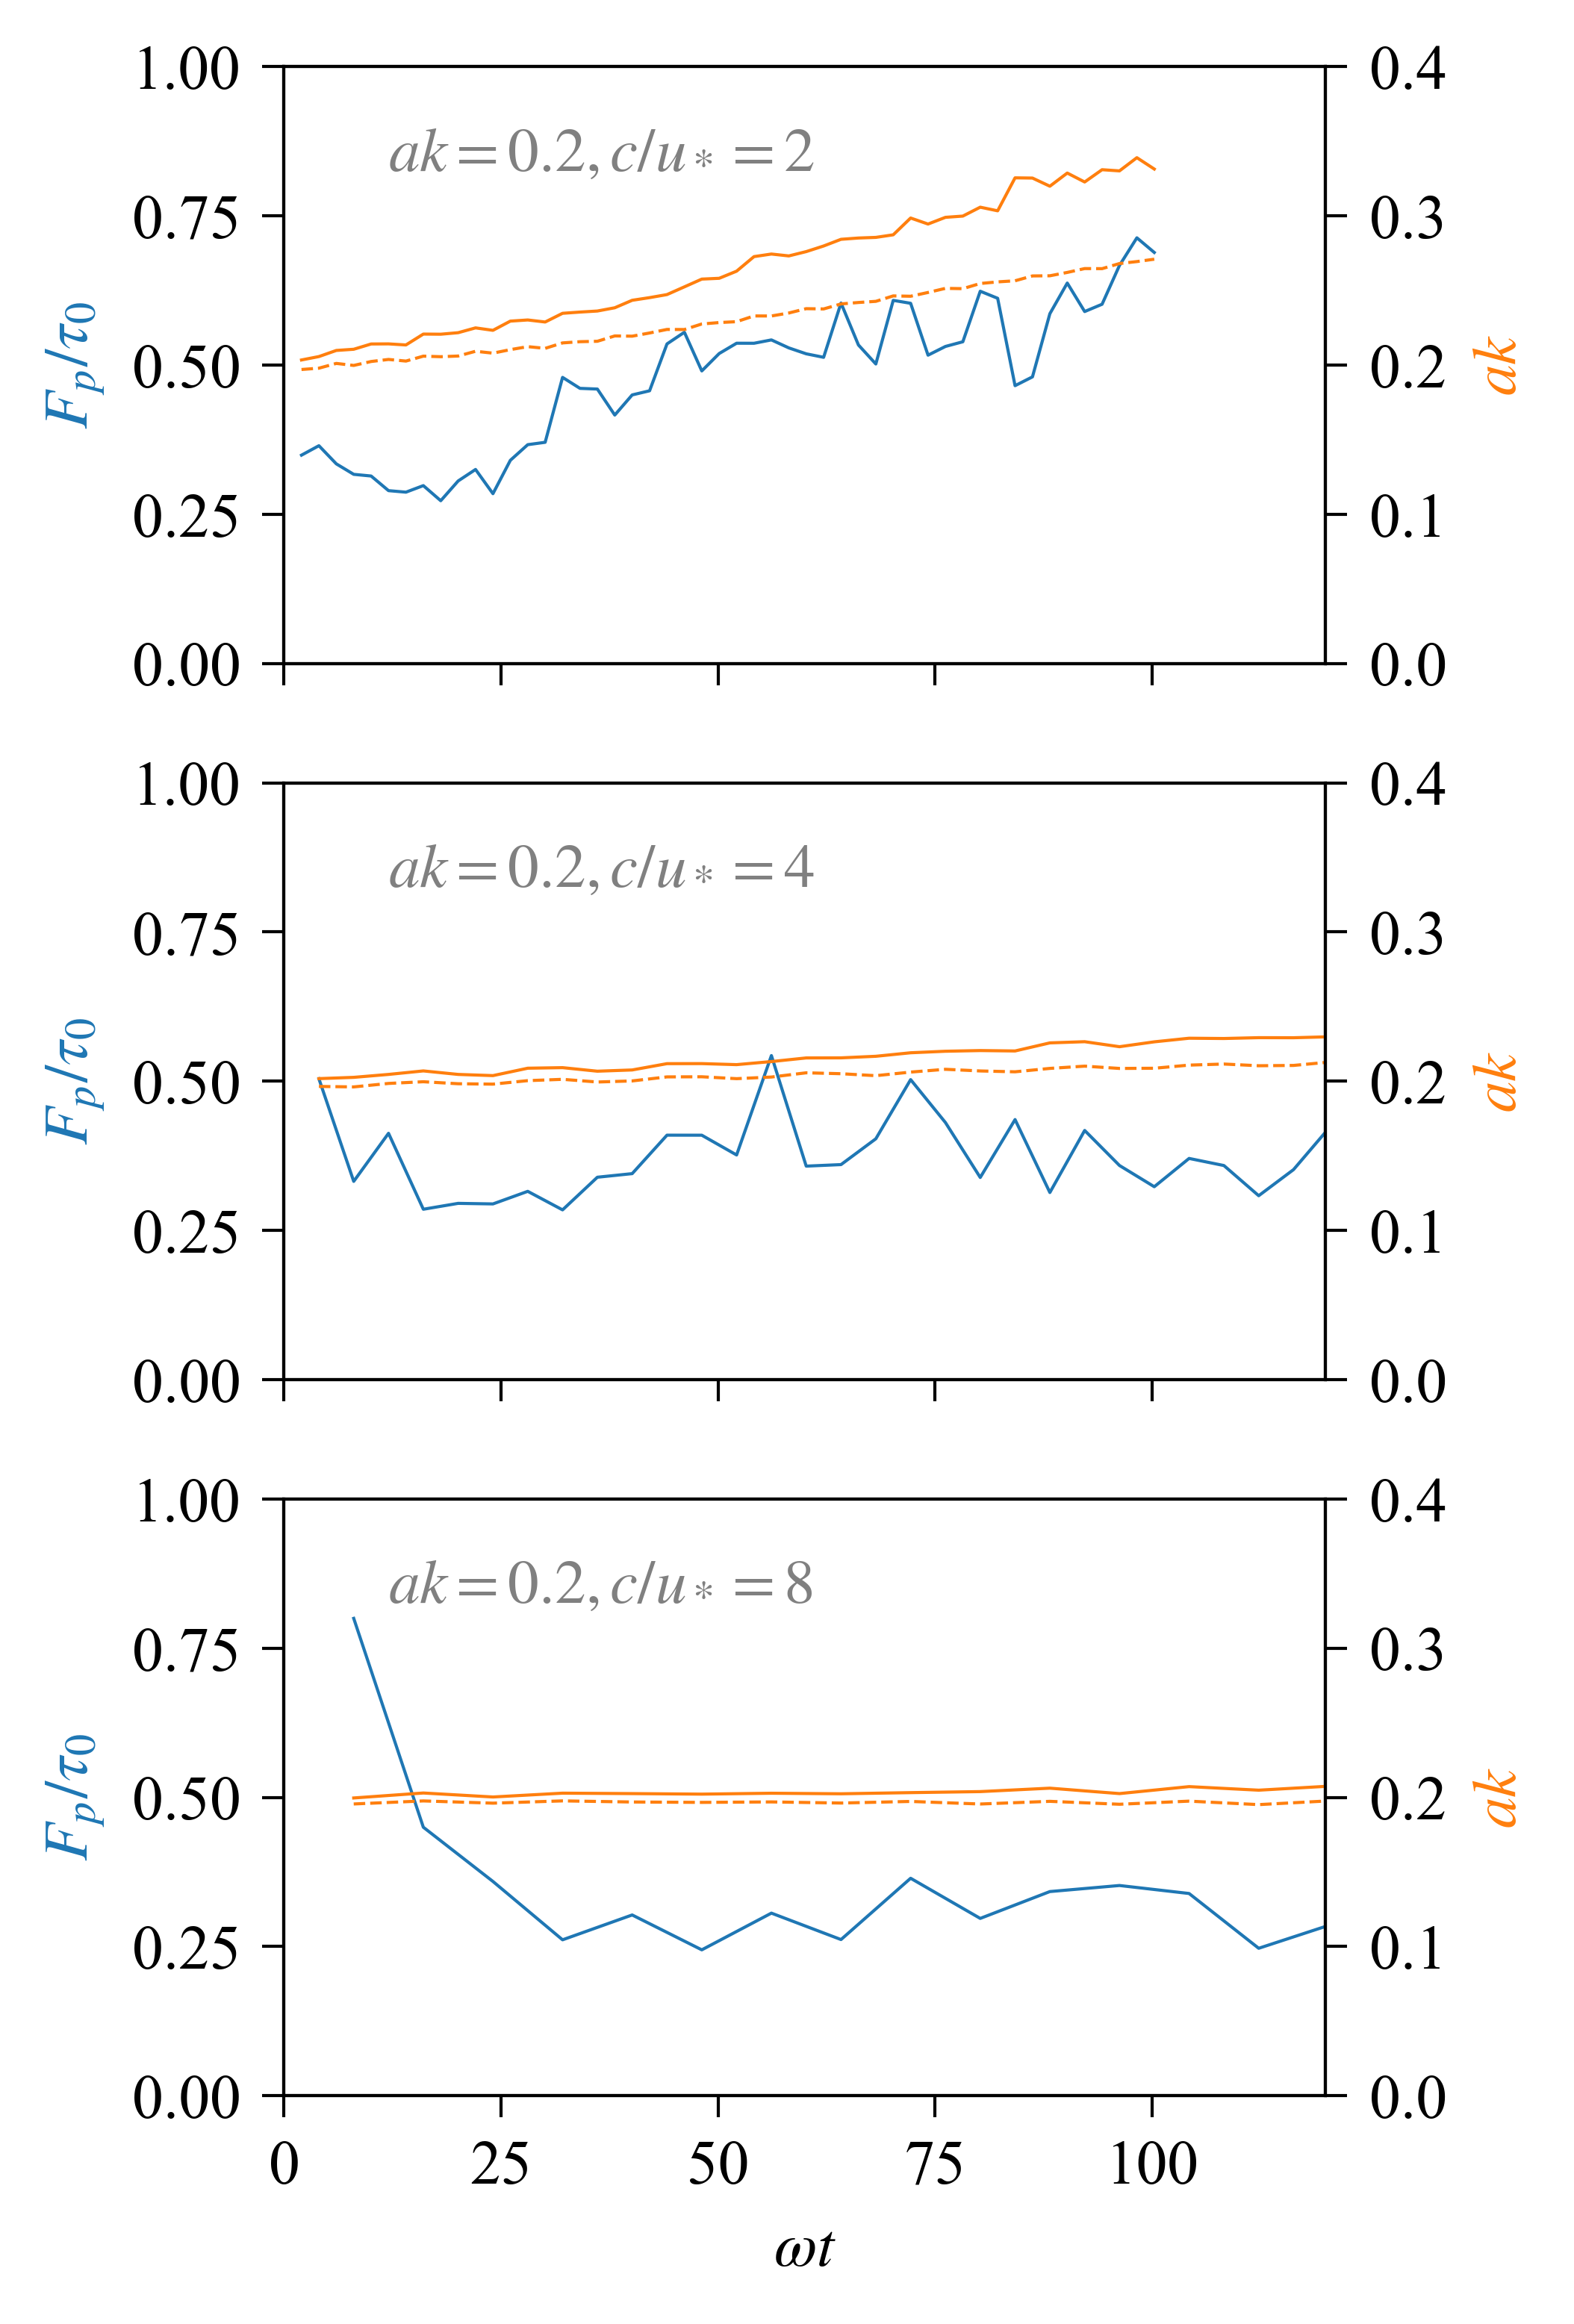

In [133]:
""" Visualization of the sequence """ 
fig, axes = plt.subplots(3,1, sharex='col', figsize=[3,6], gridspec_kw={'height_ratios':[1,1,1], "wspace":0.15, "hspace":0.2})

arms_max = []; arms_min = []
app_max = []; app_min = []

for (i,case) in enumerate((case1,case2,case3)):
# for (i,case) in enumerate((case7,case9,case11)):
# for (i,case) in enumerate((case4,case5,case6)):
# for (i,case) in enumerate((case14,case15,case16)):
    variance = [np.var(eta) for eta in case.phase['eta']] 
    pp = [(eta.max()-eta.min())/2. for eta in case.phase['eta']] 
    axes[i].plot(np.array(case.p['t'])*case.wave.omega, case.Fp/case.rho2/case.ustar**2, lw=0.5)
    ax1 = axes[i].twinx()
    ax1.plot(np.array(case.phase['t'])*case.wave.omega, np.array(variance)**0.5*1.41*case.k, '--', c='C1', lw=0.5)
    ax1.plot(np.array(case.phase['t'])*case.wave.omega, np.array(pp)*case.k, c='C1', lw=0.5)
    arms_max.append(np.array(variance).max()); arms_min.append(np.array(variance).min())
    app_max.append(np.array(pp).max()); app_min.append(np.array(pp).min())
    axes[i].set_ylim([0., 1])
    ax1.set_ylim([0., 0.4])
    axes[i].set_ylabel(r'$F_p/\tau_0$', c='C0'); ax1.set_ylabel('$ak$', c='C1')
    axes[i].annotate(r'$ak=%g, c/u_*=%.f$' %(case.ak,case.wave.c/case.ustar), xy=(0.1, 0.9), ha='left', va='top', xycoords='axes fraction', c='gray')

axes[2].set_xlabel('$\omega t$')
axes[2].set_xlim([0,120])

In [ ]:
fig, axes = plt.subplots(3,1, sharex='col', figsize=[3,6], gridspec_kw={'height_ratios':[1,1,1], "wspace":0.15, "hspace":0.2})

arms_max = []; arms_min = []
app_max = []; app_min = []
# for (i,case) in enumerate((case1,case2,case3)):
# for (i,case) in enumerate((case7,case9,case11)):
for (i,case) in enumerate((case7,case8,case10)):
# for (i,case) in enumerate((case4,case5,case6)):
# for (i,case) in enumerate((case_rerun4,case_rerun5,case_rerun6)):
# for (i,case) in enumerate((case_rerun1,case_rerun2,case_rerun3)):
    variance = [np.var(eta) for eta in case.phase['eta']] 
    pp = [(eta.max()-eta.min())/2. for eta in case.phase['eta']] 
    axes[i].plot(np.array(case.p['t'])*case.wave.omega, case.Fp/case.rho2/case.ustar**2, lw=0.5)
    ax1 = axes[i].twinx()
    ax1.plot(np.array(case.phase['t'])*case.wave.omega, np.array(variance)**0.5*1.41*case.k, '--', c='C1', lw=0.5)
    ax1.plot(np.array(case.phase['t'])*case.wave.omega, np.array(pp)*case.k, c='C1', lw=0.5)
    arms_max.append(np.array(variance).max()); arms_min.append(np.array(variance).min())
    app_max.append(np.array(pp).max()); app_min.append(np.array(pp).min())
    axes[i].set_ylim([0., 1])
    ax1.set_ylim([0., 0.4])
    axes[i].set_ylabel(r'$F_p/\tau_0$', c='C0'); ax1.set_ylabel('$ak$', c='C1')
    axes[i].annotate(r'$ak=%g, c/u_*=%.f$' %(case.ak,case.wave.c/case.ustar), xy=(0.03, 0.95), ha='left', va='top', xycoords='axes fraction', c='gray')

axes[2].set_xlabel('$\omega t$')
axes[2].set_xlim([0,200])

### <a class="anchor" id="3">Update plots of Fp and Sin </a>
[back](#0)

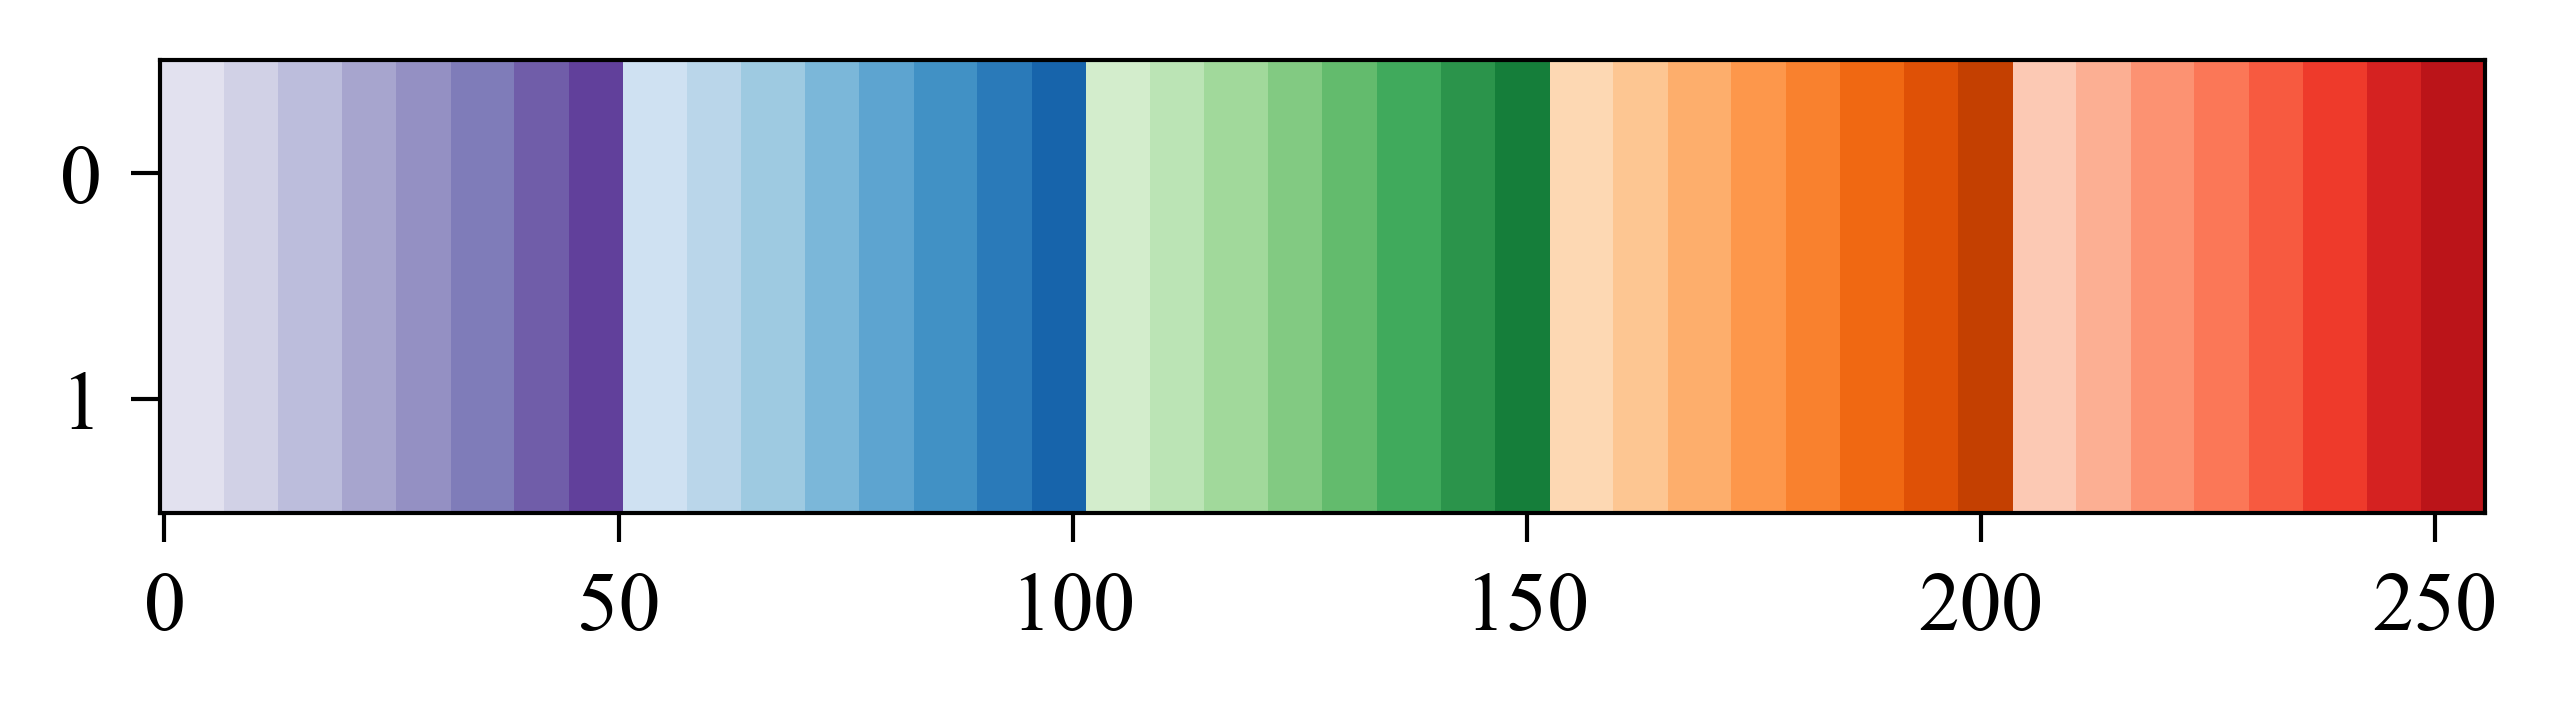

In [19]:
N = 8 # number of colors to extract from each of the base_cmaps below
base_cmaps = ['Purples','Blues','Greens','Oranges','Reds',]

n_base = len(base_cmaps)
# we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
colors = np.concatenate([plt.get_cmap(name)(np.linspace(0.2,0.8,N)) for name in base_cmaps])
cmap = mpl.colors.ListedColormap(colors) 

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(1,1,figsize=(5,1))
ax.imshow(gradient, aspect='auto', cmap=cmap)

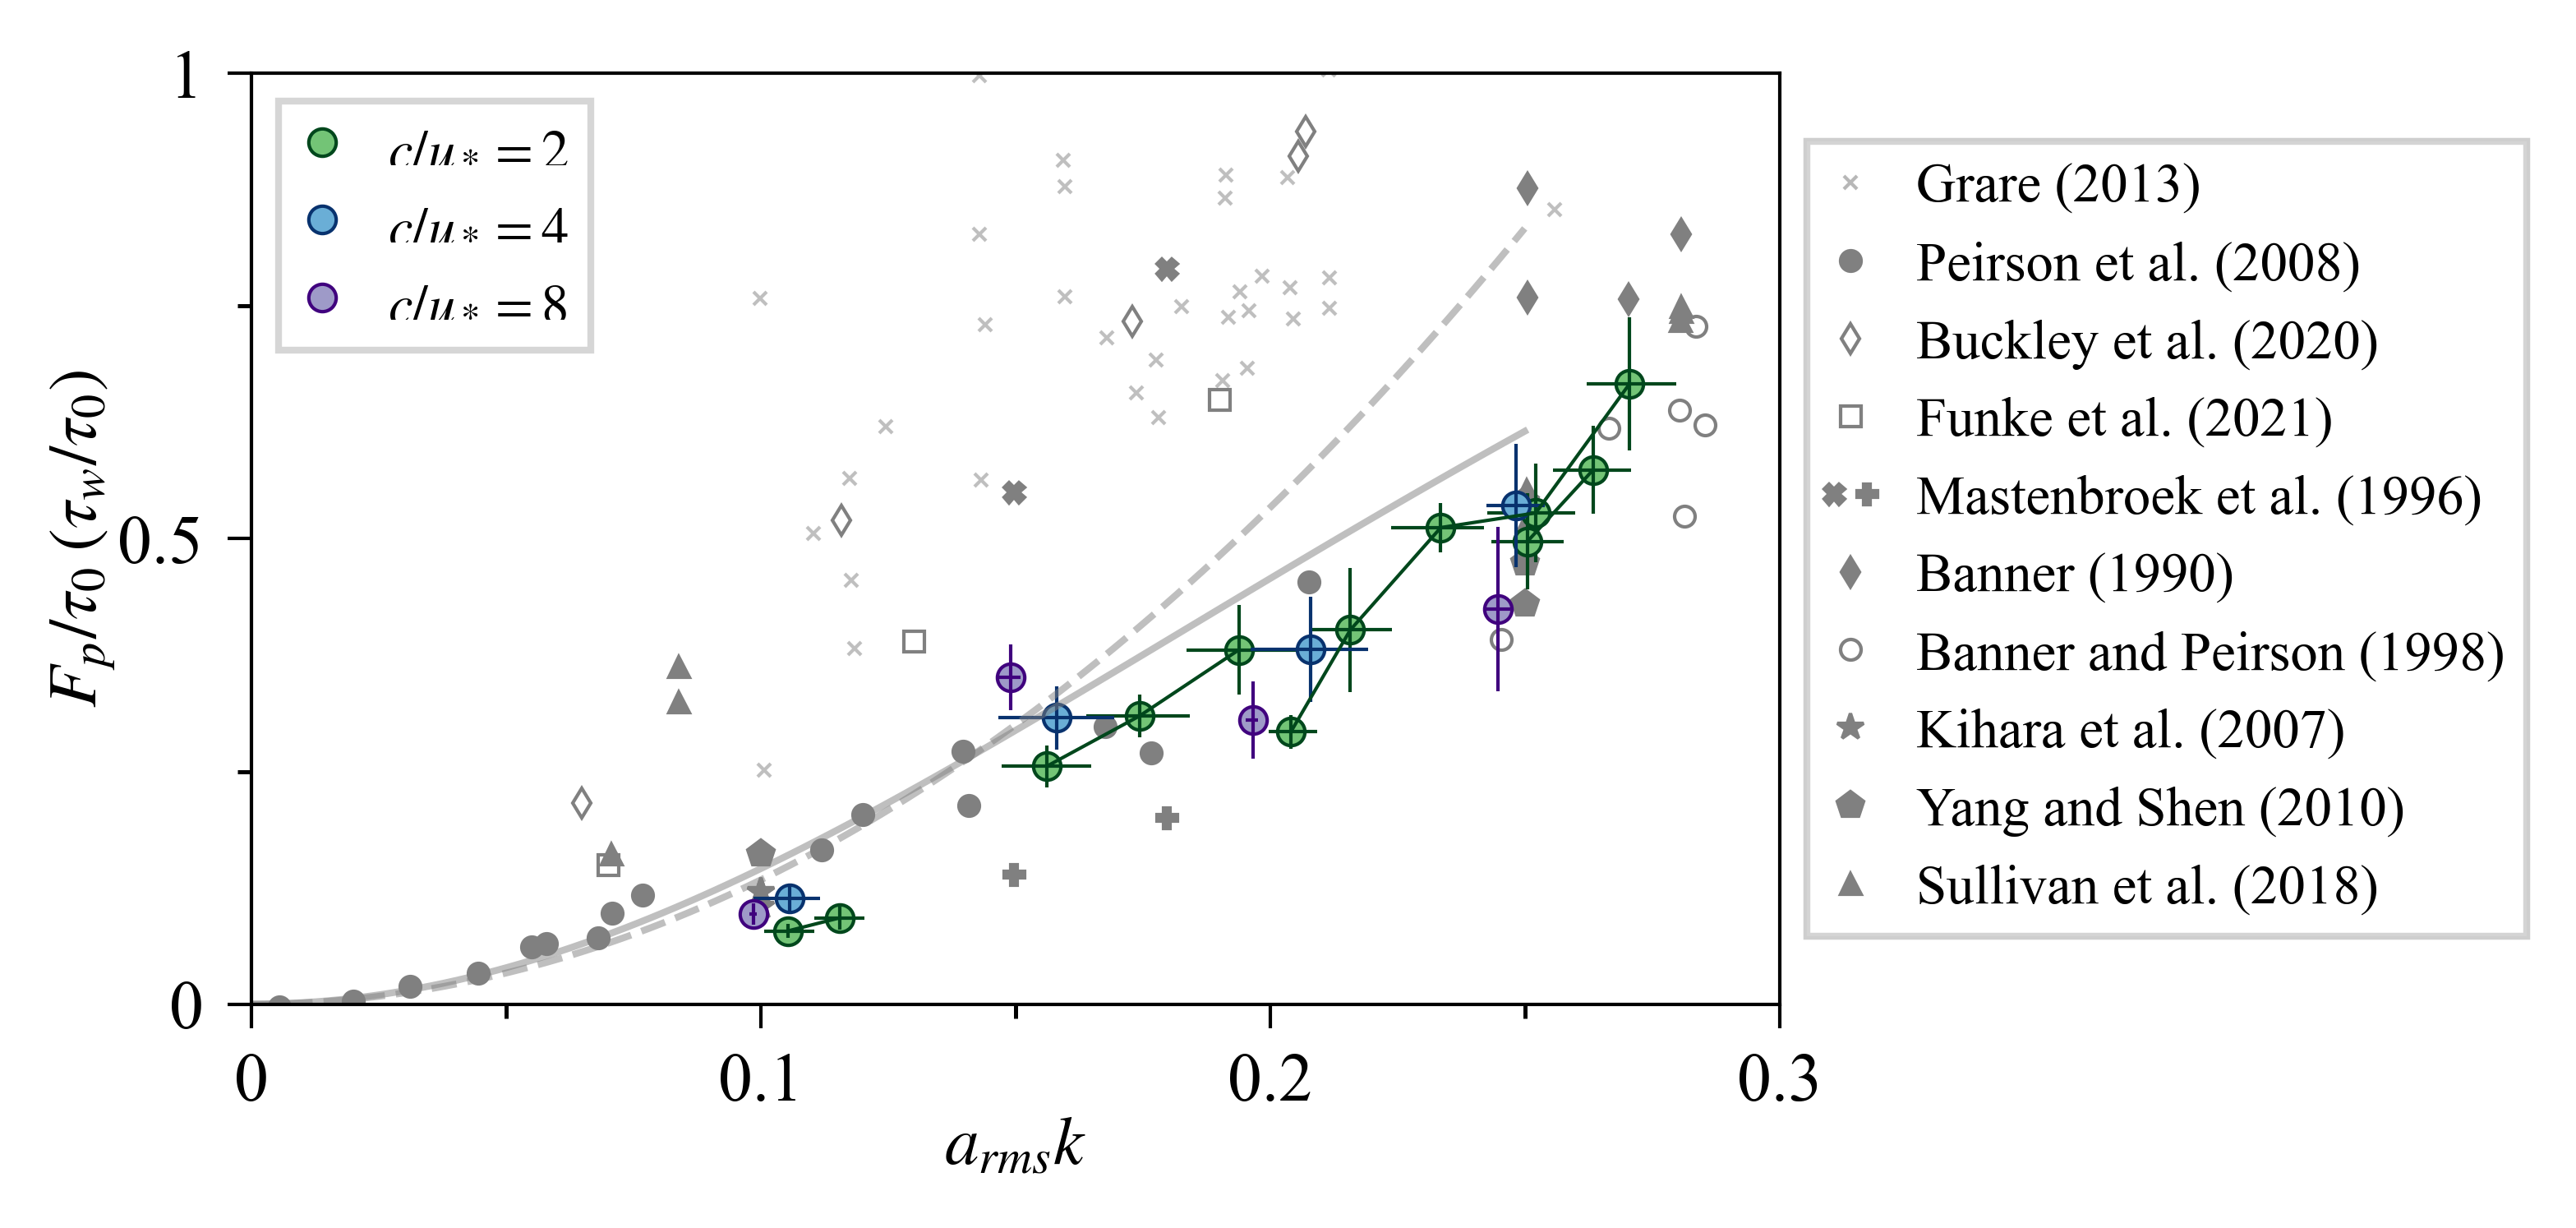

In [52]:
""" FIGURE: drag force compared to literature. Data as range """

fig = plt.figure(figsize=[4,2.5]); ax = plt.gca()
# c = plt.get_cmap('Orange')(np.linspace(0.2,0.8,N))


Kihara_phi = pd.read_csv('otherdata/extracted_data/Kihara_phi.csv', names=['z_CU0','phi_CU0','z_CU2','phi_CU2','z_CU4','phi_CU4','z_CU8','phi_CU8','z_CU12','phi_CU12','z_CU16','phi_CU16'], 
                         delimiter=',', skiprows=2)
Kihara_CU = np.array((0,2,4,8))
Kihara_phi0 = np.array((Kihara_phi.phi_CU0[0],Kihara_phi.phi_CU2[1],Kihara_phi.phi_CU4[0],Kihara_phi.phi_CU8[0]))*180 # The first point of CU2 is for some reason not right
Kihara_pamp = pd.read_csv('otherdata/extracted_data/Kihara_pamp.csv', names=['z_CU0','pamp_CU0','z_CU2','pamp_CU2','z_CU4','pamp_CU4','z_CU8','pamp_CU8','z_CU12','pamp_CU12','z_CU16','pamp_CU16'], 
                         delimiter=',', skiprows=2)
Kihara_pamp0 = np.array((Kihara_pamp.pamp_CU0[0],Kihara_pamp.pamp_CU2[1],Kihara_pamp.pamp_CU4[0],Kihara_pamp.pamp_CU8[0]))
Kihara_Fp = 0.5*Kihara_pamp0*0.1**2*np.sin(Kihara_phi0/180*np.pi)

Grare = pd.read_csv('otherdata/Fp/Grare2009_Fp.csv', names=['ak', 'drag'], delimiter = ',')
Peirson2008 = pd.read_csv('otherdata/Fp/Peirson2008_Fp.csv', names=['ak', 'drag'], delimiter = ',')
Veron = pd.read_csv('otherdata/Fp/Veron2020_Fp.csv', names=['ak', 'drag'], delimiter = ',')
Masterboenk = pd.read_csv('otherdata/Fp/Masterboenk1996_Fp.csv', names=['ak', 'drag'], delimiter = ',')
Banner1990 = pd.read_csv('otherdata/Fp/Banner1990_Fp.csv', names=['ak', 'drag'], delimiter = ',')
Banner1998 = pd.read_csv('otherdata/Fp/Banner1998_Fp.csv', names=['ak', 'drag'], delimiter = ',')
Sullivan2018 = pd.read_csv('otherdata/Fp/Sullivan2018_Fp.csv', names=['ak', 'drag'], delimiter = ',')

d1, = plt.plot(Grare['ak'], Grare['drag'], marker='x', mfc='none', lw=0, markersize=2, markeredgewidth=0.5, alpha=0.5, color='gray', label='Grare 2009')
d2, = plt.plot(Peirson2008['ak'], Peirson2008['drag'], marker='o', lw=0, markersize=3, markeredgewidth=0.5, alpha=1, color='gray', label='Perison 2008')
""" Add colors for the Veron case later! """
# for (UC_,beta_,ak_) in zip(UC,beta,ak):
#     cchoice = plt.get_cmap('Oranges')((ak_-0.075)/(0.25-0.075)*0.6+0.2) ### RESCALE!
#     plt.plot(UC_, beta_/2/np.pi, marker='d', mfc='none', 
#              lw=0, markersize=3, markeredgewidth=0.5, color=cchoice)
d3, = plt.plot(Veron['ak'], Veron['drag'], marker='d', mfc='none', lw=0, markersize=3, markeredgewidth=0.5, alpha=1, 
               color='gray', label='Veron 2020')
d4, = plt.plot((0.07, 0.13, 0.19), (0.15, 0.39, 0.65), marker='s', mfc='none', lw=0, markersize=3, markeredgewidth=0.5, alpha=1, color='gray', label='Veron 2020 processed')
d5, = plt.plot(Masterboenk['ak'], Masterboenk['drag'], marker='X', lw=0, markersize=3, markeredgewidth=0.5, alpha = 1, color='gray', label='Masterboenk 1996')
d6, = plt.plot(Masterboenk['ak'], 0.5*12.4*Masterboenk['ak']**2, marker='P', lw=0, markersize=3, alpha = 1, markeredgewidth=0.5, color='gray', label='Masterboenk 1996')
d7, = plt.plot(0.1, Kihara_Fp[1], marker='*', lw=0, markersize=4, alpha = 1, markeredgewidth=0.5, color='gray')
d7, = plt.plot(0.1, Kihara_Fp[2], marker='*', lw=0, markersize=4, alpha = 1, markeredgewidth=0.5, color='gray')
d7, = plt.plot(0.1, Kihara_Fp[3], marker='*', lw=0, markersize=4, alpha = 1, markeredgewidth=0.5, color='gray')
d8, = plt.plot((0.1, 0.25, 0.25, 0.25),(0.161, 0.474, 0.54, 0.43), marker='p', lw=0, markersize=4, alpha = 1, markeredgewidth=0.5, color='gray')
d9, = plt.plot(Banner1990['ak'], Banner1990['drag'], marker='d', lw=0, markersize=3, markeredgewidth=0.5, alpha=1, color='gray', label='Banner 1990')
d10, = plt.plot(Banner1998['ak'], Banner1998['drag'], marker='o', lw=0, markersize=3, mfc='none', markeredgewidth=0.5, alpha=1, color='gray', label='Banner and Peirson 1998')
d11, = plt.plot(Sullivan2018['ak'], Sullivan2018['drag'], marker='^', lw=0, markersize=3, markeredgewidth=0.5, alpha=1, color='gray', label='Sullivan et al. 2018')


# plt.xlabel(r'$a_{pp}k$', labelpad=0)
plt.xlabel(r'$a_{rms}k$', labelpad=0)
plt.ylabel(r'$F_p/\tau_0 \; (\tau_w/\tau_0)$', labelpad=0)
plt.ylim([0,1.0])
plt.xlim([0,0.3])

for case in (case1,case4,case7,case14):
    xerror = [-(np.array(case.Fp_stat['arms_min'])-np.array(case.Fp_stat['arms_mean']))*case.k, (np.array(case.Fp_stat['arms_max'])-np.array(case.Fp_stat['arms_mean']))*case.k]
    yerror = [np.array(case.Fp_stat['Fp_std'])/case.rho2/case.ustar**2, np.array(case.Fp_stat['Fp_std'])/case.rho2/case.ustar**2]
    marker1, = plt.plot(np.array(case.Fp_stat['arms_mean'])*case.k, np.array(case.Fp_stat['Fp_mean'])/case.rho2/case.ustar**2, marker='o', mfc=plt.get_cmap('Greens')(0.5), lw=0, markersize=4, 
             markeredgecolor=plt.get_cmap('Greens')(0.99), alpha = 1, markeredgewidth=0.5)
    plt.errorbar(np.array(case.Fp_stat['arms_mean'])*case.k, np.array(case.Fp_stat['Fp_mean'])/case.rho2/case.ustar**2, xerr=xerror, yerr=yerror, c=plt.get_cmap('Greens')(0.99), lw=0.5)

for case in (case2,case5,case9,case15):
# for case in (case2,case_rerun5,case_rerun2,case15):
    xerror = [[-(case.Fp_stat['arms_min']-case.Fp_stat['arms_mean'])*case.k], [(case.Fp_stat['arms_max']-case.Fp_stat['arms_mean'])*case.k]]
    yerror = [[case.Fp_stat['Fp_std']/case.rho2/case.ustar**2], [case.Fp_stat['Fp_std']/case.rho2/case.ustar**2]]
    marker2, = plt.plot(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, marker='o', mfc=plt.get_cmap('Blues')(0.5), lw=0, markersize=4, 
             color=plt.get_cmap('Blues')(0.99), alpha = 1, markeredgewidth=0.5)
    plt.errorbar(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, xerr= xerror, yerr = yerror, c=plt.get_cmap('Blues')(0.99), lw=0.5)

for case in (case3,case6,case11,case16):
# for case in (case3,case_rerun6,case_rerun3,case16):
    xerror = [[-(case.Fp_stat['arms_min']-case.Fp_stat['arms_mean'])*case.k], [(case.Fp_stat['arms_max']-case.Fp_stat['arms_mean'])*case.k]]
    yerror = [[case.Fp_stat['Fp_std']/case.rho2/case.ustar**2], [case.Fp_stat['Fp_std']/case.rho2/case.ustar**2]]
    marker3, = plt.plot(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, marker='o', mfc=plt.get_cmap('Purples')(0.5), lw=0, markersize=4, 
             color=plt.get_cmap('Purples')(0.99), alpha = 1, markeredgewidth=0.5)
    plt.errorbar(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, xerr= xerror, yerr = yerror, c=plt.get_cmap('Purples')(0.99), lw=0.5)

# for case in (case_rerun1,case_rerun4):
#     xerror = [[-(case.Fp_stat['arms_min']-case.Fp_stat['arms_mean'])*case.k], [(case.Fp_stat['arms_max']-case.Fp_stat['arms_mean'])*case.k]]
#     yerror = [[case.Fp_stat['Fp_std']/case.rho2/case.ustar**2], [case.Fp_stat['Fp_std']/case.rho2/case.ustar**2]]
#     marker3, = plt.plot(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, marker='^', mfc=plt.get_cmap('Greens')(0.5), lw=0, markersize=4, 
#              color=plt.get_cmap('Greens')(0.99), alpha = 1, markeredgewidth=0.5)
#     plt.errorbar(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, xerr= xerror, yerr = yerror, c=plt.get_cmap('Greens')(0.99), lw=0.5)

# for case in (case_rerun2,case_rerun5):
#     xerror = [[-(case.Fp_stat['arms_min']-case.Fp_stat['arms_mean'])*case.k], [(case.Fp_stat['arms_max']-case.Fp_stat['arms_mean'])*case.k]]
#     yerror = [[case.Fp_stat['Fp_std']/case.rho2/case.ustar**2], [case.Fp_stat['Fp_std']/case.rho2/case.ustar**2]]
#     marker3, = plt.plot(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, marker='^', mfc=plt.get_cmap('Blues')(0.5), lw=0, markersize=4, 
#              color=plt.get_cmap('Blues')(0.99), alpha = 1, markeredgewidth=0.5)
#     plt.errorbar(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, xerr= xerror, yerr = yerror, c=plt.get_cmap('Blues')(0.99), lw=0.5)

# for case in (case_rerun3,case_rerun6):
#     xerror = [[-(case.Fp_stat['arms_min']-case.Fp_stat['arms_mean'])*case.k], [(case.Fp_stat['arms_max']-case.Fp_stat['arms_mean'])*case.k]]
#     yerror = [[case.Fp_stat['Fp_std']/case.rho2/case.ustar**2], [case.Fp_stat['Fp_std']/case.rho2/case.ustar**2]]
#     marker3, = plt.plot(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, marker='^', mfc=plt.get_cmap('Purples')(0.5), lw=0, markersize=4, 
#              color=plt.get_cmap('Purples')(0.99), alpha = 1, markeredgewidth=0.5)
#     plt.errorbar(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, xerr= xerror, yerr = yerror, c=plt.get_cmap('Purples')(0.99), lw=0.5)

# for case in (case1,case2,case3,case4,case5,case6,case7,case9,case11,case14,case15,case16):
#     xerror = [[-(case.Fp_stat['arms_min']-case.Fp_stat['arms_mean'])*case.k], [(case.Fp_stat['arms_max']-case.Fp_stat['arms_mean'])*case.k]]
#     yerror = [[-case.Fp_stat['Fp_std']], [case.Fp_stat['Fp_std']]
#     plt.plot(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, marker='^', mfc=plt.get_cmap('Oranges')(1-case.wave.c/case.ustar/10), lw=0, markersize=4, 
#              color=plt.get_cmap('Oranges')(0.99), alpha = 1, markeredgewidth=0.5)
#     plt.errorbar(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, xerr= xerror, yerr = yerror, c=plt.get_cmap('Oranges')(1-case.wave.c/case.ustar/10), lw=0.5)

# for case in (case1,case2,case3,case4,case5,case6,case7,case9,case11,case14,case15,case16):
#     xerror = [[-(case.Fp_stat['arms_min']-case.Fp_stat['arms_mean'])*case.k], [(case.Fp_stat['arms_max']-case.Fp_stat['arms_mean'])*case.k]]
#     yerror = [[-(case.Fp_stat['Fp_min']-case.Fp_stat['Fp_mean'])/case.rho2/case.ustar**2], [(case.Fp_stat['Fp_max']-case.Fp_stat['Fp_mean'])/case.rho2/case.ustar**2]]
#     plt.plot(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, marker='^', mfc=plt.get_cmap('Oranges')(1-case.wave.c/case.ustar/10), lw=0, markersize=4, 
#              color=plt.get_cmap('Oranges')(0.99), alpha = 1, markeredgewidth=0.5)
#     plt.errorbar(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, xerr= xerror, yerr = yerror, c=plt.get_cmap('Oranges')(1-case.wave.c/case.ustar/10), lw=0.5)

# for case in (case1,case2,case3,case4,case5,case6,case7,case9,case11,case14,case15,case16):
#     xerror = [[-(case.Fp_stat['app_min']-case.Fp_stat['app_mean'])*case.k], [(case.Fp_stat['app_max']-case.Fp_stat['app_mean'])*case.k]]
#     yerror = [[-(case.Fp_stat['Fp_min']-case.Fp_stat['Fp_mean'])/case.rho2/case.ustar**2], [(case.Fp_stat['Fp_max']-case.Fp_stat['Fp_mean'])/case.rho2/case.ustar**2]]
#     plt.plot(case.Fp_stat['app_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, marker='^', mfc=plt.get_cmap('Oranges')(1-case.wave.c/case.ustar/10), lw=0, markersize=4, 
#              color=plt.get_cmap('Oranges')(0.99), alpha = 1, markeredgewidth=0.5)
#     plt.errorbar(case.Fp_stat['app_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, xerr= xerror, yerr = yerror, c=plt.get_cmap('Oranges')(1-case.wave.c/case.ustar/10), lw=0.5)


x1 = np.linspace(0,0.25,100)
y1 = x1**2*(0.3/0.15**2)
y2 = x1*1.2*(x1)/(1+6*x1**2)*(0.3/0.15**2)
beta_f = 20; beta_t = 12
y2 = x1**2*(beta_f+beta_t)/(2+beta_f*x1**2)
l1, = plt.plot(x1, y1, c='gray', linestyle='--', alpha=0.5, lw=1)
l2, = plt.plot(x1, y2, c='gray', linestyle='-', alpha=0.5, lw=1)

# legend1 = plt.legend([(p1,p2,p3),l1,l2], [r'$c/u_*=2,4,8$',r'$\frac{1}{2}\beta(ak)^2$','Correction by Belcher'],
#                        handler_map={tuple: HandlerTuple(ndivide=None)}, loc='center left', bbox_to_anchor=(0.01, 0.8), frameon=False, handlelength=2, fontsize=8)
# legend1 = plt.legend([(p1,p2,p3)], ['Current study\n' + '$c/u_*=2,4,8$'],
#                        handler_map={tuple: HandlerTuple(ndivide=None)}, loc='center left', bbox_to_anchor=(0.01, 0.85), frameon=False, handlelength=2)
legend1 = plt.legend([marker1,marker2,marker3], ['$c/u_*=2$','$c/u_*=4$','$c/u_*=8$'], loc='upper left', fancybox=False, fontsize=8, handlelength=0.8)
legend2 = plt.legend([d1,d2,d3,d4,(d5,d6),d9,d10,d7,d8,d11], ['Grare (2013)','Peirson et al. (2008)','Buckley et al. (2020)','Funke et al. (2021)', 'Mastenbroek et al. (1996)', 
                                                   'Banner (1990)', 'Banner and Peirson (1998)','Kihara et al. (2007)', 'Yang and Shen (2010)', 'Sullivan et al. (2018)'],
                    handler_map={tuple: HandlerTuple(ndivide=None)}, loc='center left', bbox_to_anchor=(1, 0.5), fancybox=False, fontsize=8, handlelength=0.8)
ax.add_artist(legend1)
ax.add_artist(legend2)

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

majorLocator = MultipleLocator(0.1)
majorFormatter = FormatStrFormatter('%g')
minorLocator = MultipleLocator(0.05)

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
# for the minor ticks, use no labels; default NullFormatter
ax.xaxis.set_minor_locator(minorLocator)

majorLocator = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%g')
minorLocator = MultipleLocator(0.25)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
# for the minor ticks, use no labels; default NullFormatter
ax.yaxis.set_minor_locator(minorLocator)
# ax.set_yticks(np.arange(0,1.6,0.4))
# ax.set_xticks(np.arange(0,0.4,0.1))
fig.savefig('review/drag_coefficient.pdf', bbox_inches='tight')

In [ ]:
""" Plot the energy (but change the background!)"""
fig = plt.figure(figsize=[5,3]); ax = plt.gca()

""" All other data """
# Kihara 2007
Kihara = pd.read_csv('otherdata/beta/Kihara2007.csv', names=['CU', 'beta'], delimiter = ',')
Kihara = Kihara.sort_values(by='CU', ascending=True)
ax.plot(1/Kihara.CU, Kihara.beta/Kihara.CU**2/850, marker='p', mfc='none',
        lw=0, markersize=3, markeredgewidth=0.5, color=cmap(33), alpha=1)
# Yang 2013: LES with broadband spectrum 
Yang2013_CU6 = pd.read_csv('otherdata/beta/Yang2013_CU6.csv', names=['CU', 'beta'], delimiter = ',')
Yang2013_CU10 = pd.read_csv('otherdata/beta/Yang2013_CU10.csv', names=['CU', 'beta'], delimiter = ',')
ax.plot(1/Yang2013_CU6['CU'], Yang2013_CU6['beta']/Yang2013_CU6['CU']**2/850, marker='x', mfc='none', 
        lw=0, markersize=3, markeredgewidth=0.5, color=cmap(15), alpha=1)
ax.plot(1/Yang2013_CU10['CU'], Yang2013_CU10['beta']/Yang2013_CU10['CU']**2/850, marker='x', mfc='none',
        lw=0, markersize=3, markeredgewidth=0.5, color=cmap(13), alpha=1)
# Buckley 2020
UC = np.array((0.152,0.256,0.382,0.556,0.645))
beta = np.array((0.017, 0.038, 0.054, 0.11, 0.13))
ak = np.array((0.06, 0.12, 0.17, 0.2, 0.21)) # color value 0.2 ->
for (UC_,beta_,ak_) in zip(UC,beta,ak):
    cchoice = plt.get_cmap('Reds')((ak_-0.075)/(0.25-0.075)*0.6+0.2) ### RESCALE!
    plt.plot(UC_, beta_/2/np.pi, marker='d', mfc='none', 
             lw=0, markersize=3, markeredgewidth=0.5, color=cchoice)
# Add color bar

# Plants 1982 compiled
# Shemdin 1967, triangle
UC = np.array((0.285,0.217,0.192,0.176,0.139,0.0998,0.0696))
beta = np.array((0.0137,0.00843,0.00599,0.00532,0.00330,0.00160,0.000464))
ax.plot(UC, beta/2/np.pi, marker='^', mfc='none',
        lw=0, markersize=3, markeredgewidth=0.5, color='gray', alpha=1)
# Snyder 1981, open circle
Snyder1 = pd.read_csv('otherdata/beta/Snyder1981_fixed.csv', names=['UC', 'beta'], delimiter = ',')
ax.plot(Snyder1.UC, Snyder1.beta/2/np.pi, marker='o', mfc='none',
        lw=0, markersize=3, markeredgewidth=0.5, color='gray', alpha=1)
# Snyder 1981, open square
Snyder2 = pd.read_csv('otherdata/beta/Snyder1981_follow.csv', names=['UC', 'beta'], delimiter = ',')
ax.plot(Snyder2.UC, Snyder2.beta/2/np.pi, marker='s', mfc='none',
        lw=0, markersize=3, markeredgewidth=0.5, color='gray', alpha=1)
# Wu 1979
Wu = pd.read_csv('otherdata/beta/Wu1979.csv', names=['UC', 'beta'], delimiter = ',')
ax.plot(Wu.UC, Wu.beta/2/np.pi, marker='x', mfc='none',
        lw=0, markersize=3, markeredgewidth=0.5, color='gray', alpha=1)

# Plant's estimation
# β = (0.04 ± 0.02)(u∗/c)2
UC = 10**(np.linspace(-2,0,100))
plt.plot(UC, 0.06*UC**2, '--', lw=1, c='gray', alpha=0.5)
plt.plot(UC, 0.02*UC**2, '--', lw=1, c='gray', alpha=0.5)

ratio = (0.25-0.1)/(0.6*7/8) # ak per unit colour
vmin = 0.1 - ratio*(0.2+0.6*1/8)
vmax = 0.25 + ratio*0.2
print(vmin,vmax)
ax2  = fig.add_axes([0.8,0.20,0.01,0.3])
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
cbar = mpl.colorbar.ColorbarBase(ax2,cmap='Reds',norm=norm,orientation='vertical',ticks=(0.1,0.15,0.2,0.25))
cbar.ax.text(0.5, 1.1, r'$a_{rms}k$', ha='center', va='center', transform=cbar.ax.transAxes)
ax2.tick_params(axis='both', which='major', labelsize=8)


# for case in (case14,case15,case18,case16):
#     p1, = ax.plot(case.ustar/case.wave.c, case.Fp_aver*case.wave.c/case.E_rms[0]/case.wave.omega, marker='^',
#                   lw=0, markersize=4, mfc=cmap(39), color=plt.get_cmap('Reds')(0.99), alpha = 1, markeredgewidth=0.5)
# for case in (case1,case2,case19,case3):
#     p1, = ax.plot(case.ustar/case.wave.c, case.Fp_aver*case.wave.c/case.E_rms[0]/case.wave.omega, marker='^', 
#                   lw=0, markersize=4, mfc=cmap(37), color=plt.get_cmap('Reds')(0.99), alpha = 1, markeredgewidth=0.5)
# for case in (case7,case9,case8,case10,case11):
#     p3, = ax.plot(case.ustar/case.wave.c, case.Fp_aver*case.wave.c/case.E_rms[0]/case.wave.omega, marker='^',
#                   lw=0, markersize=4, mfc=cmap(35), color=plt.get_cmap('Reds')(0.99), alpha = 1, markeredgewidth=0.5)
# for case in (case4,case5,case17,case6):
#     p5, = ax.plot(case.ustar/case.wave.c, case.Fp_aver*case.wave.c/case.E_rms[0]/case.wave.omega, marker='^', 
#                   lw=0, markersize=4, mfc=cmap(33), color=plt.get_cmap('Reds')(0.99), alpha = 1, markeredgewidth=0.5)
    
    
for case in (case1,case4,case7,case14):
#     xerror = [-(np.array(case.Fp_stat['arms_min'])-np.array(case.Fp_stat['arms_mean']))*case.k, (np.array(case.Fp_stat['arms_max'])-np.array(case.Fp_stat['arms_mean']))*case.k]
#     yerror = [np.array(case.Fp_stat['Fp_std'])/case.rho2/case.ustar**2, np.array(case.Fp_stat['Fp_std'])/case.rho2/case.ustar**2]
    for i, Fp_mean in enumerate(case.Fp_stat['Fp_mean']):
        cchoice = plt.get_cmap('Reds')((case.Fp_stat['arms_mean'][i]*case.k-0.075)/(0.25-0.075)*0.6+0.2) ### RESCALE!
        marker1, = ax.plot(case.ustar/case.wave.c, Fp_mean*case.wave.c/(case.Fp_stat['arms_mean'][i]**2/2*case.g*case.rho1)/case.wave.omega, 
                           marker='^', c=cchoice, lw=1, markersize=4, markeredgecolor=plt.get_cmap('Reds')(0.99), alpha = 1, markeredgewidth=0.5)

# for case in (case2,case_rerun5,case_rerun2,case15):
for case in (case2,case5,case9,case15):
    cchoice = plt.get_cmap('Reds')((case.Fp_stat['arms_mean']*case.k-0.075)/(0.25-0.075)*0.6+0.2) ### RESCALE!
    marker1, = ax.plot(case.ustar/case.wave.c, case.Fp_stat['Fp_mean']*case.wave.c/(case.Fp_stat['arms_mean']**2/2*case.g*case.rho1)/case.wave.omega, 
                       marker='^', c=cchoice, lw=1, markersize=4, markeredgecolor=plt.get_cmap('Reds')(0.99), alpha = 1, markeredgewidth=0.5)
#     plt.errorbar(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, xerr= xerror, yerr = yerror, c=plt.get_cmap('Blues')(0.99), lw=0.5)

# for case in (case3,case_rerun6,case10,case8,case_rerun3,case16,case17,case18,case19):
for case in (case3,case6,case8,case10,case11,case16,case17,case18,case19):
#     yerror = [Fp_mean*case.wave.c/(case.Fp_stat['arms_mean']**2/2*case.g*case.rho1)/case.wave.omega, [case.Fp_stat['Fp_std']/case.rho2/case.ustar**2]]
    cchoice = plt.get_cmap('Reds')((case.Fp_stat['arms_mean']*case.k-0.075)/(0.25-0.075)*0.6+0.2) ### RESCALE!
    marker1, = ax.plot(case.ustar/case.wave.c, case.Fp_stat['Fp_mean']*case.wave.c/(case.Fp_stat['arms_mean']**2/2*case.g*case.rho1)/case.wave.omega, 
                       marker='^', c=cchoice, lw=1, markersize=4, markeredgecolor=plt.get_cmap('Reds')(0.99), alpha = 1, markeredgewidth=0.5)
#     plt.errorbar(case.Fp_stat['arms_mean']*case.k, case.Fp_stat['Fp_mean']/case.rho2/case.ustar**2, xerr= xerror, yerr = yerror, c=plt.get_cmap('Purples')(0.99), lw=0.5)




ax.set_xlabel(r'$u_{\ast}/c$', labelpad=0)
ax.set_ylabel(r'$\gamma = S_{p}/(\omega E)$', labelpad=0)
ax.set_xlim([0.04, 1])
ax.set_xscale('log')
ax.set_ylim([0.00001, 0.1])
ax.set_yscale('log')
fig.savefig('review/Growthrate_comp.pdf', bbox_inches='tight')
fig.savefig('review/Growthrate_comp.eps', bbox_inches='tight')

0.021428571428571436 0.30714285714285716


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.005376299133705995
0.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


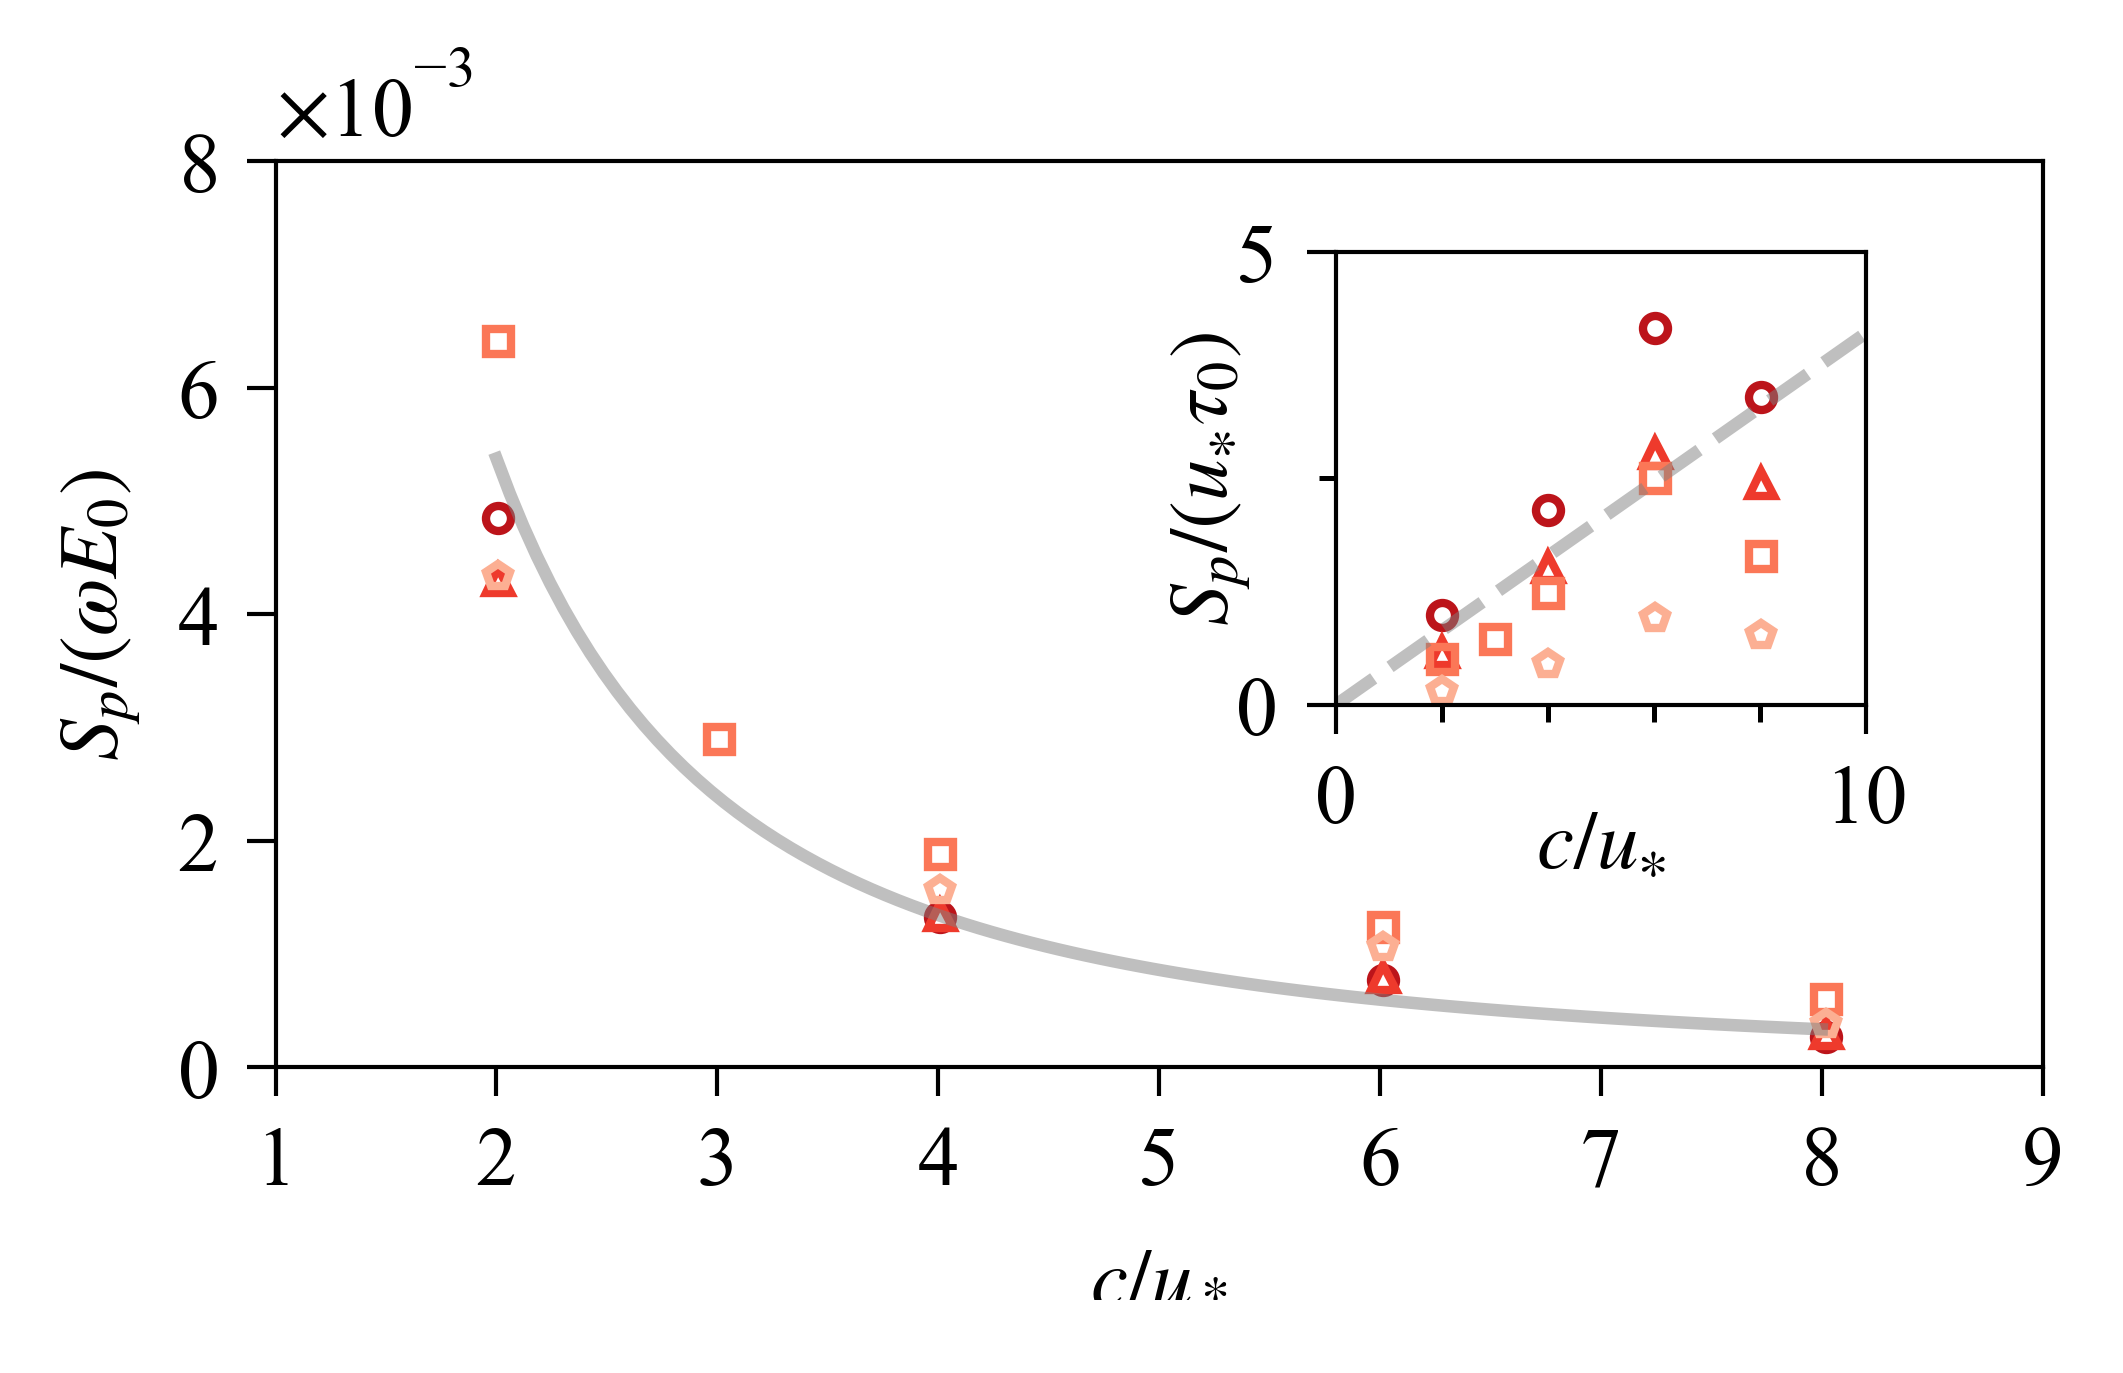

In [72]:
""" FIGURE: Fp*c and dE/dt """
fig = plt.figure(figsize=[3.8,2]); ax1 = plt.gca()
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
from matplotlib import ticker
# Manually set the position and relative size of the inset axes within ax1
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.6,0.4,0.3,0.5])
ax2.set_axes_locator(ip)

# for case in (case14,case15,case16,case18):
#     p0, = ax1.plot(case.wave.c/case.ustar, (np.average(case.pamp)/case.tau0/case.ak), marker='o', mfc='none', 
#                   lw=0, markersize=3, color=cmap(39), alpha = 1)
# for case in (case1,case2,case3):
#     p1, = ax1.plot(case.wave.c/case.ustar, (np.average(case.pamp)/case.tau0/case.ak), marker='^', mfc='none', 
#                    lw=0, markersize=3, color=cmap(37), alpha = 1)
# for case in (case7,case9,case8,case10,case11):
#     p3, = ax1.plot(case.wave.c/case.ustar, (np.average(case.pamp)/case.tau0/case.ak), marker='s', mfc='none',
#                    lw=0, markersize=3, color=cmap(35), alpha = 1)
# for case in (case4,case5,case6,case17):
#     p5, = ax1.plot(case.wave.c/case.ustar, (np.average(case.pamp)/case.tau0/case.ak), marker='p', mfc='none',
#                    lw=0, markersize=3, color=cmap(33), alpha = 1)

""" Normalized in a commonly seen way """
for case in (case14,case15,case18,case16):
    p7, = ax1.plot(case.wave.c/case.ustar, case.Fp_aver*case.wave.c/(case.arms_aver**2/2*case.g*case.rho1)/case.wave.omega, marker='o', mfc='none',
                   lw=0, markersize=3, color=cmap(39), alpha = 1)
for case in (case1,case2,case19,case3):
    p1, = ax1.plot(case.wave.c/case.ustar, case.Fp_aver*case.wave.c/(case.arms_aver**2/2*case.g*case.rho1)/case.wave.omega, marker='^', mfc='none',
                   lw=0, markersize=3, color=cmap(37), alpha = 1)
# for case in (case_rerun1,case8,case_rerun2,case10,case_rerun3):
for case in (case7,case9,case8,case10,case11):
    p3, = ax1.plot(case.wave.c/case.ustar, case.Fp_aver*case.wave.c/(case.arms_aver**2/2*case.g*case.rho1)/case.wave.omega, marker='s', mfc='none',
                   lw=0, markersize=3, color=cmap(35), alpha = 1)
# for case in (case_rerun4,case_rerun5,case17,case_rerun6):
for case in (case4,case5,case17,case6):
    p5, = ax1.plot(case.wave.c/case.ustar, case.Fp_aver*case.wave.c/(case.arms_aver**2/2*case.g*case.rho1)/case.wave.omega, marker='p', mfc='none',
                   lw=0, markersize=3, color=cmap(33), alpha = 1)
    
# for case in (case2,case_rerun5,case_rerun2,case15):
# # for case in (case2,case5,case9,case15):

    
# l = ax1.legend([(p7),(p1),(p3),(p5)], [r'$ak=0.25$', r'$ak=0.20$',r'$ak=0.15$',r'$ak=0.10$'],
#                handler_map={tuple: HandlerTuple(ndivide=None)}, loc='center left', bbox_to_anchor=(0.15, 0.75), fancybox=False, handlelength=0.5)

x1 = np.linspace(2,8,100)
case = case1
y1 = 5*(1/x1)**2*case.Fp_aver*case.wave.c/(case.arms_aver**2/2*case.g*case.rho1)/case.wave.omega
print(y1[0])
ax1.plot(x1, y1, c='gray',alpha=0.5)


""" Inset: Normalized in another way """
for case in (case14,case15,case18,case16):
    case.tau0 = case.ustar**2*case.rho2
    p7, = ax2.plot(case.wave.c/case.ustar, case.Fp_aver*case.wave.c/(case.tau0*case.ustar), marker='o', mfc='none',
                   lw=0, markersize=3, color=cmap(39), alpha = 1)
for case in (case1,case2,case19,case3):
    case.tau0 = case.ustar**2*case.rho2
    p1, = ax2.plot(case.wave.c/case.ustar, case.Fp_aver*case.wave.c/(case.tau0*case.ustar), marker='^', mfc='none',
                   lw=0, markersize=3, color=cmap(37), alpha = 1)
# for case in (case_rerun1,case8,case_rerun2,case10,case_rerun3):
for case in (case7,case9,case8,case10,case_rerun3):
    case.tau0 = case.ustar**2*case.rho2
    p3, = ax2.plot(case.wave.c/case.ustar, case.Fp_aver*case.wave.c/(case.tau0*case.ustar), marker='s', mfc='none',
                   lw=0, markersize=3, color=cmap(35), alpha = 1)
# for case in (case_rerun4,case_rerun5,case17,case_rerun6):
for case in (case4,case5,case17,case6):
    case.tau0 = case.ustar**2*case.rho2
    p5, = ax2.plot(case.wave.c/case.ustar, case.Fp_aver*case.wave.c/(case.tau0*case.ustar), marker='p', mfc='none',
                   lw=0, markersize=3, color=cmap(33), alpha = 1)
    
x1 = np.linspace(0,10,100)
case = case1
y1 = x1*case.Fp_aver*case.wave.c/(case.tau0*case.ustar)*0.7
print(y1[0])
ax2.plot(x1, y1, c='gray', linestyle='--', alpha=0.5)

ax1.set_xlim([1,9])
ax1.set_ylim([0,0.8*10**(-2)])
ax2.set_xlim([0,10])
ax2.set_ylim([0,5])
ax1.set_xlabel(r'$c/u_*$')
ax1.set_ylabel(r'$S_{p}/(\omega E_0)$')
ax2.set_xlabel(r'$c/u_{\ast}$', labelpad=-4)
ax2.set_ylabel(r'$S_p/(u_{\ast}\tau_0)$', labelpad=-2)
ax1.set_xticks(np.arange(1,10,1))
ax1.set_yticks(np.arange(0,1,0.2)*10**(-2))
ax2.set_yticks(((0,5)))
ax2.set_xticks(((0,10)))
formatter1 = ticker.ScalarFormatter(useMathText=True)
formatter1.set_scientific(True) 
formatter1.set_powerlimits((-1,1)) 
# formatter2 = ticker.ScalarFormatter(useMathText=True)
# formatter2.set_scientific(True) 
# formatter2.set_powerlimits((-1,1))
# ax2.yaxis.set_major_formatter(formatter2) 
ax1.yaxis.set_major_formatter(formatter1) 
ax2.xaxis.set_minor_locator(MultipleLocator(2))
ax2.yaxis.set_minor_locator(MultipleLocator(2.5))
fig.savefig('review/energy_rate.pdf', bbox_inches='tight')
fig.savefig('review/energy_rate.eps', bbox_inches='tight')

### <a class="anchor" id="4">The breaking case </a>
With case_rerun7, rerun8, rerun9 from ReadIn_new.ipynb
[back](#0)

In [6]:
""" Slightly different with the function above. Test with the height of the pressure """
def processing_energy1 (case):
    case.Fp = np.zeros(len(case.p['p_2D']))
    case.p_1D = np.zeros((len(case.p['p_2D']), 512))
    case.grad = np.zeros((len(case.p['p_2D']), 512))
    for i in tqdm(range(0, len(case.p['p_2D']))):
        # Find time of eta and f
        etai = np.where(np.isclose(case.phase['t'], case.p['t'][i]))[0][0]
        f_2D = case.f_2D[-1]
#         fieldi = np.where(np.isclose(case.field_t, case.p['t'][i]))[0][0]
#         f_2D = case.f_2D[fieldi] # We don't have as big a smapling frequency for f_2D
        """ Subtract the mean """
        case.p['p_2D'][i] = case.p['p_2D'][i]*(1-f_2D)**10 # Air velocity
        paverage = np.average(case.p['p_2D'][i][:,90:512])
        case.p['p_2D'][i] = (case.p['p_2D'][i] - paverage)*(1-f_2D)**10
        """ Interpolate onto new coordinate """
        eta = np.roll(np.average(case.phase['eta'][etai], axis=0), -case.phase['idx'][etai], axis=0) - 1
        p_2D_interp, zgrid = array_newcoord(case.p['p_2D'][i], case=case, eta=eta)
        """ Smooth eta and compute the gradient """
        etahat = savgol_filter(eta, 31, 4) # window size 51, polynomial order 3
        grad = np.gradient(etahat)/(2*np.pi/512)   
#         theta = np.linspace(0,8*np.pi,512)
#         grad = -np.sin(theta)*case.k*(np.var(eta)*2)**0.5
        """ Compute the energy input """
#         p = p_2D_interp[:,88] - np.average(p_2D_interp[:,88])
        p = p_2D_interp[:,90] - np.average(p_2D_interp[:,90])
        case.p_1D[i] = p
        case.grad[i] = grad
        case.Fp[i] = np.average(p*grad)


In [7]:
for case in (case_rerun7, case_rerun8, case_rerun9):
    processing_energy1(case)
    
for case in (case_rerun7, case_rerun8, case_rerun9):
    variance = [np.var(eta) for eta in case.phase['eta']] 
    pp = [(eta.max()-eta.min())/2. for eta in case.phase['eta']]  
    # Single value stats
    case.Fp_stat = {"Fp_mean":np.average(case.Fp[10:]), "Fp_max":case.Fp[10:].max(), "Fp_min":case.Fp[10:].min(), 
                    'arms_mean':np.average(variance)**0.5*1.41, 'arms_max':np.array(variance).max()**0.5*1.41, 'arms_min':np.array(variance).min()**0.5*1.41,
                    'app_mean':np.average(pp), 'app_max':np.array(pp).max(), 'app_min':np.array(pp).min()}

100%|██████████| 66/66 [00:36<00:00,  1.78it/s]


(0.0, 80.0)

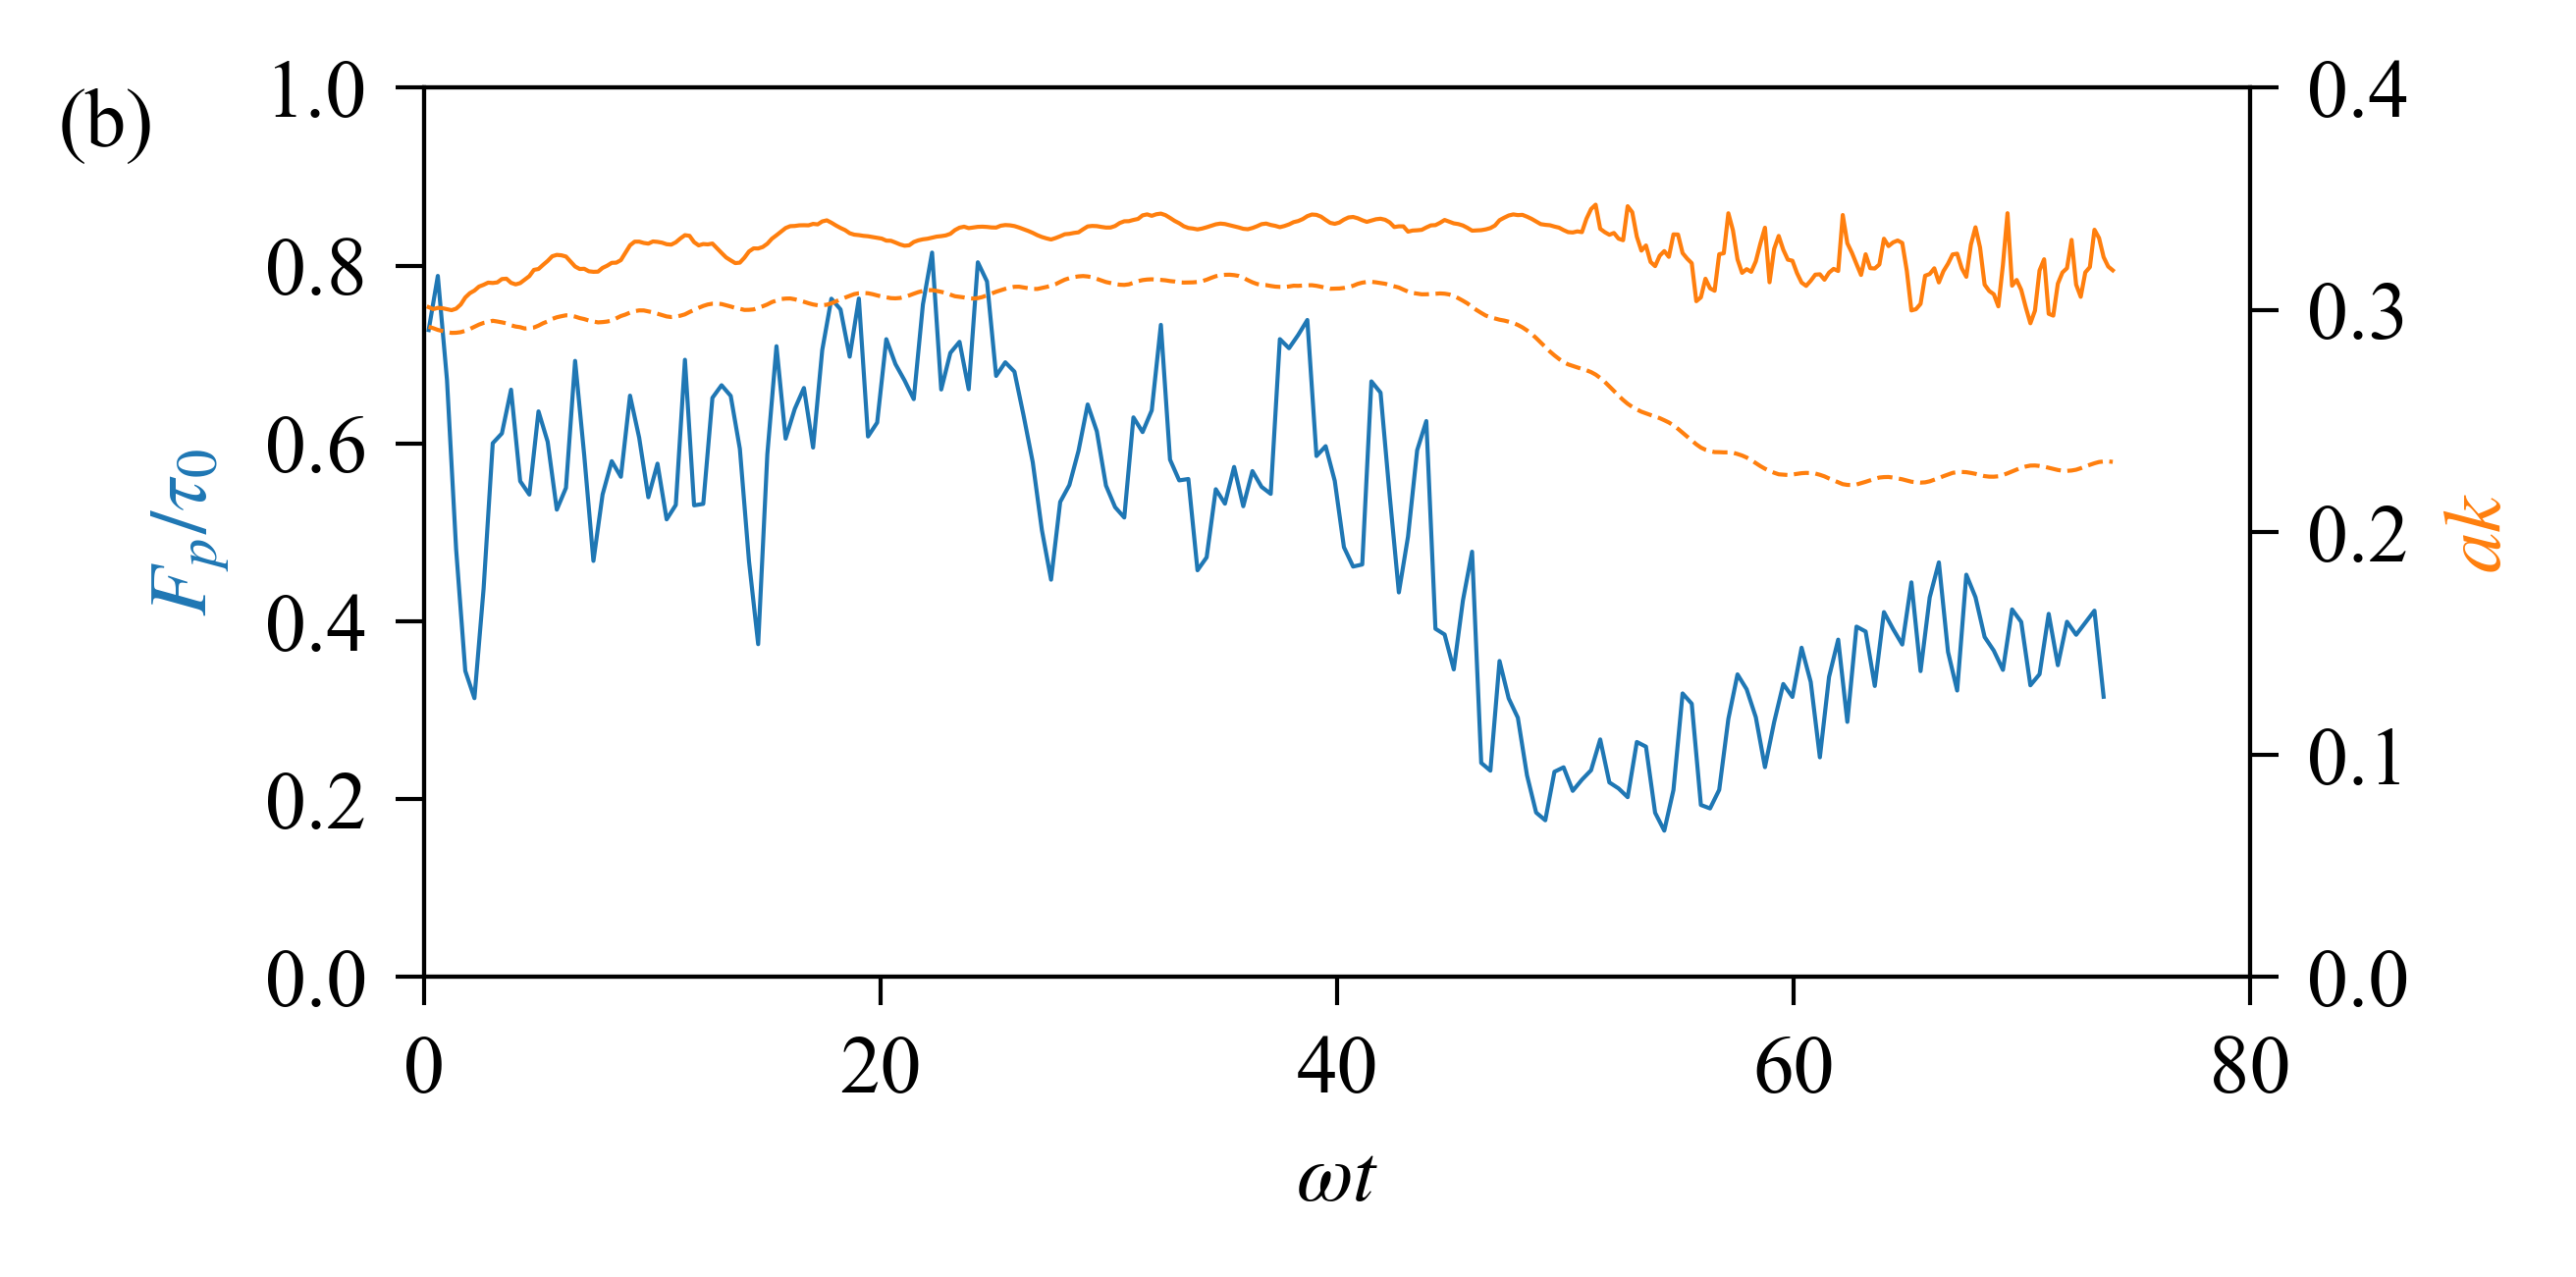

In [8]:
fig = plt.figure(figsize=[4,2]); ax = plt.gca()
case = case_rerun7
variance = [np.var(eta) for eta in case.phase['eta']] 
pp = [(eta.max()-eta.min())/2. for eta in case.phase['eta']] 
ax.plot(np.array(case.p['t'])*case.wave.omega, case.Fp/case.rho2/case.ustar**2, lw=0.5)
ax1 = ax.twinx()
ax1.plot(np.array(case.phase['t'])*case.wave.omega, np.array(variance)**0.5*1.41*case.k, '--', c='C1', lw=0.5)
ax1.plot(np.array(case.phase['t'])*case.wave.omega, np.array(pp)*case.k, c='C1', lw=0.5)
ax.set_ylim([0., 1])
ax1.set_ylim([0., 0.4])
ax.set_ylabel(r'$F_p/\tau_0$', c='C0'); ax1.set_ylabel('$ak$', c='C1')
# ax.annotate(r'$ak=%g, c/u_*=%.f$' %(case.ak,case.wave.c/case.ustar), xy=(0.03, 0.95), ha='left', va='top', xycoords='axes fraction', c='gray')

ax.annotate('(b)', xy=(-0.2, 1), ha='left', va='top', xycoords='axes fraction')
ax.set_xlabel('$\omega t$')
ax.set_xlim([0,80])
# fig.savefig('review/Fp_ak0.3_withletter.pdf', bbox_inches='tight')

(0.0, 200.0)

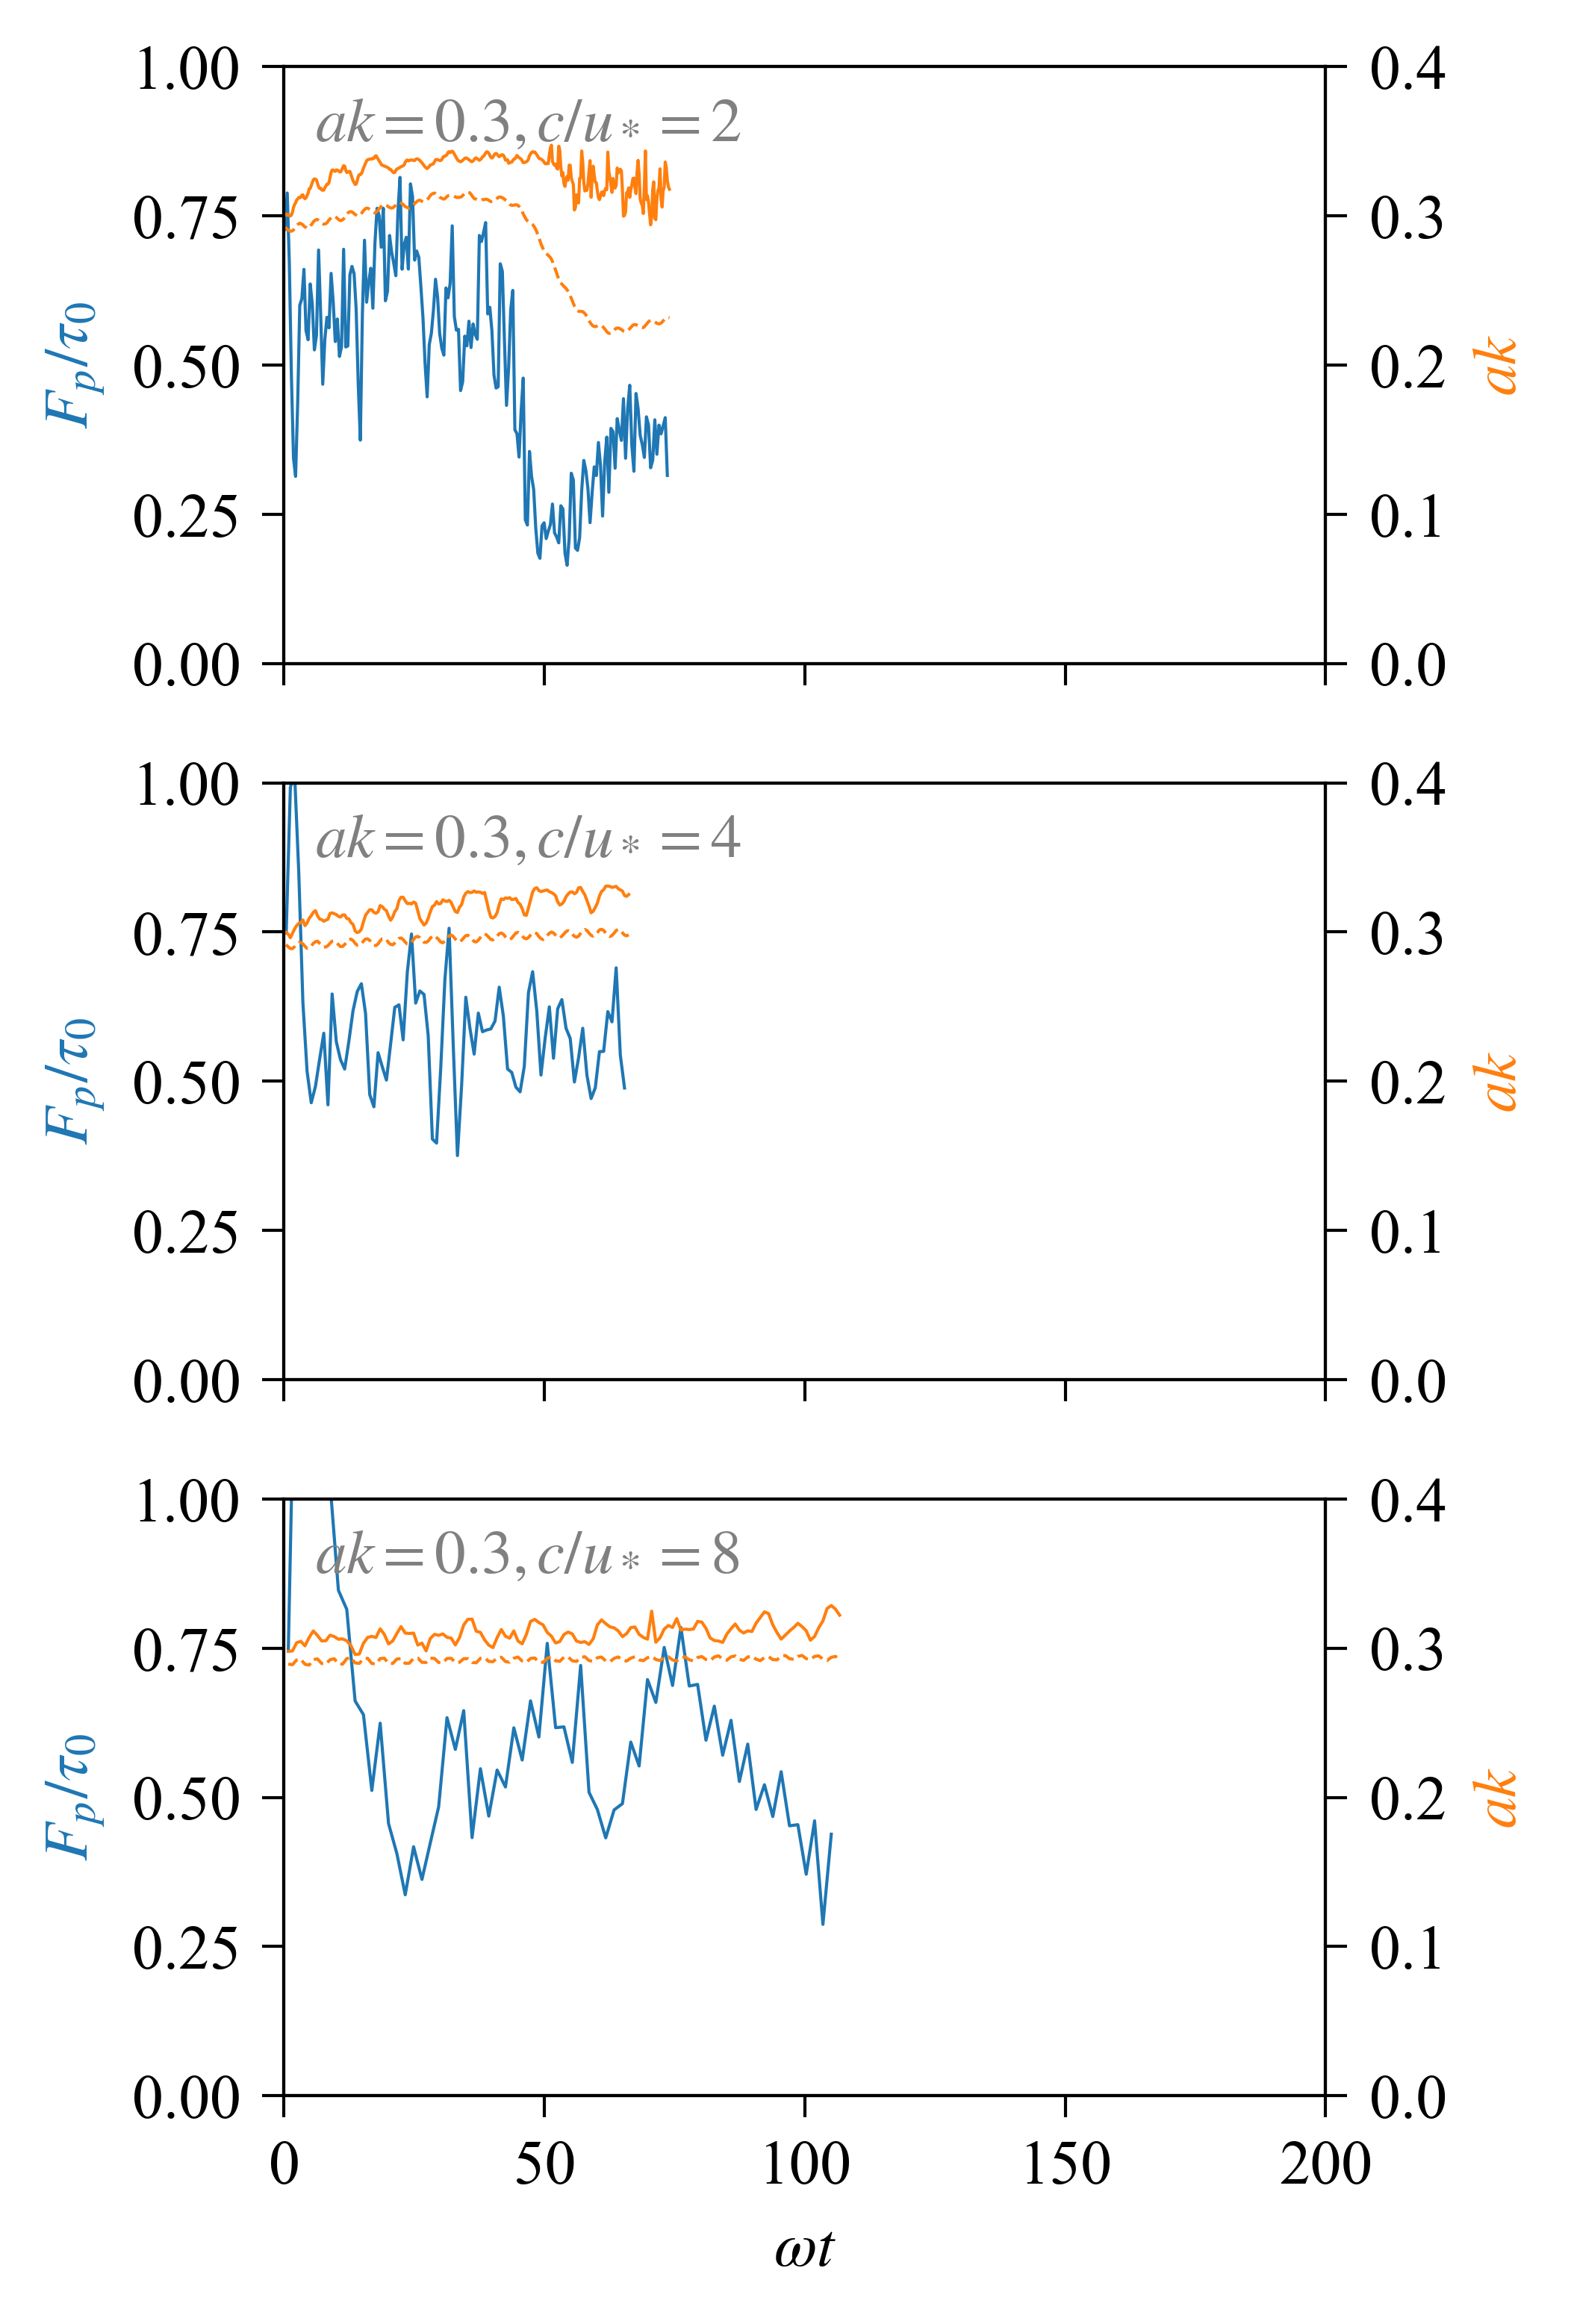

In [74]:
fig, axes = plt.subplots(1,1, sharex='col', figsize=[3,6], gridspec_kw={'height_ratios':[1,1,1], "wspace":0.15, "hspace":0.2})

arms_max = []; arms_min = []
app_max = []; app_min = []
# for (i,case) in enumerate((case1,case2,case3)):
# for (i,case) in enumerate((case7,case9,case11)):
# for (i,case) in enumerate((case4,case5,case6)):
for (i,case) in enumerate((case_rerun7,case_rerun8,case_rerun9)):
    variance = [np.var(eta) for eta in case.phase['eta']] 
    pp = [(eta.max()-eta.min())/2. for eta in case.phase['eta']] 
    axes[i].plot(np.array(case.p['t'])*case.wave.omega, case.Fp/case.rho2/case.ustar**2, lw=0.5)
    ax1 = axes[i].twinx()
    ax1.plot(np.array(case.phase['t'])*case.wave.omega, np.array(variance)**0.5*1.41*case.k, '--', c='C1', lw=0.5)
    ax1.plot(np.array(case.phase['t'])*case.wave.omega, np.array(pp)*case.k, c='C1', lw=0.5)
    arms_max.append(np.array(variance).max()); arms_min.append(np.array(variance).min())
    app_max.append(np.array(pp).max()); app_min.append(np.array(pp).min())
    axes[i].set_ylim([0., 1])
    ax1.set_ylim([0., 0.4])
    axes[i].set_ylabel(r'$F_p/\tau_0$', c='C0'); ax1.set_ylabel('$ak$', c='C1')
    axes[i].annotate(r'$ak=%g, c/u_*=%.f$' %(case.ak,case.wave.c/case.ustar), xy=(0.03, 0.95), ha='left', va='top', xycoords='axes fraction', c='gray')

axes[2].set_xlabel('$\omega t$')
axes[2].set_xlim([0,100])

### <a class="anchor" id="5">The case with different aspect ratio </a>
[back](#0)

In [23]:
for case in (case1, case_rerun_aspect):
    processing_energy_aspect(case)
    
for case in (case1, case_rerun_aspect):
    variance = [np.var(eta) for eta in case.phase['eta']] 
    pp = [(eta.max()-eta.min())/2. for eta in case.phase['eta']]  
    # Single value stats
    case.Fp_stat = {"Fp_mean":np.average(case.Fp[10:]), "Fp_max":case.Fp[10:].max(), "Fp_min":case.Fp[10:].min(), 
                    'arms_mean':np.average(variance)**0.5*1.41, 'arms_max':np.array(variance).max()**0.5*1.41, 'arms_min':np.array(variance).min()**0.5*1.41,
                    'app_mean':np.average(pp), 'app_max':np.array(pp).max(), 'app_min':np.array(pp).min()}

100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


(0.0, 200.0)

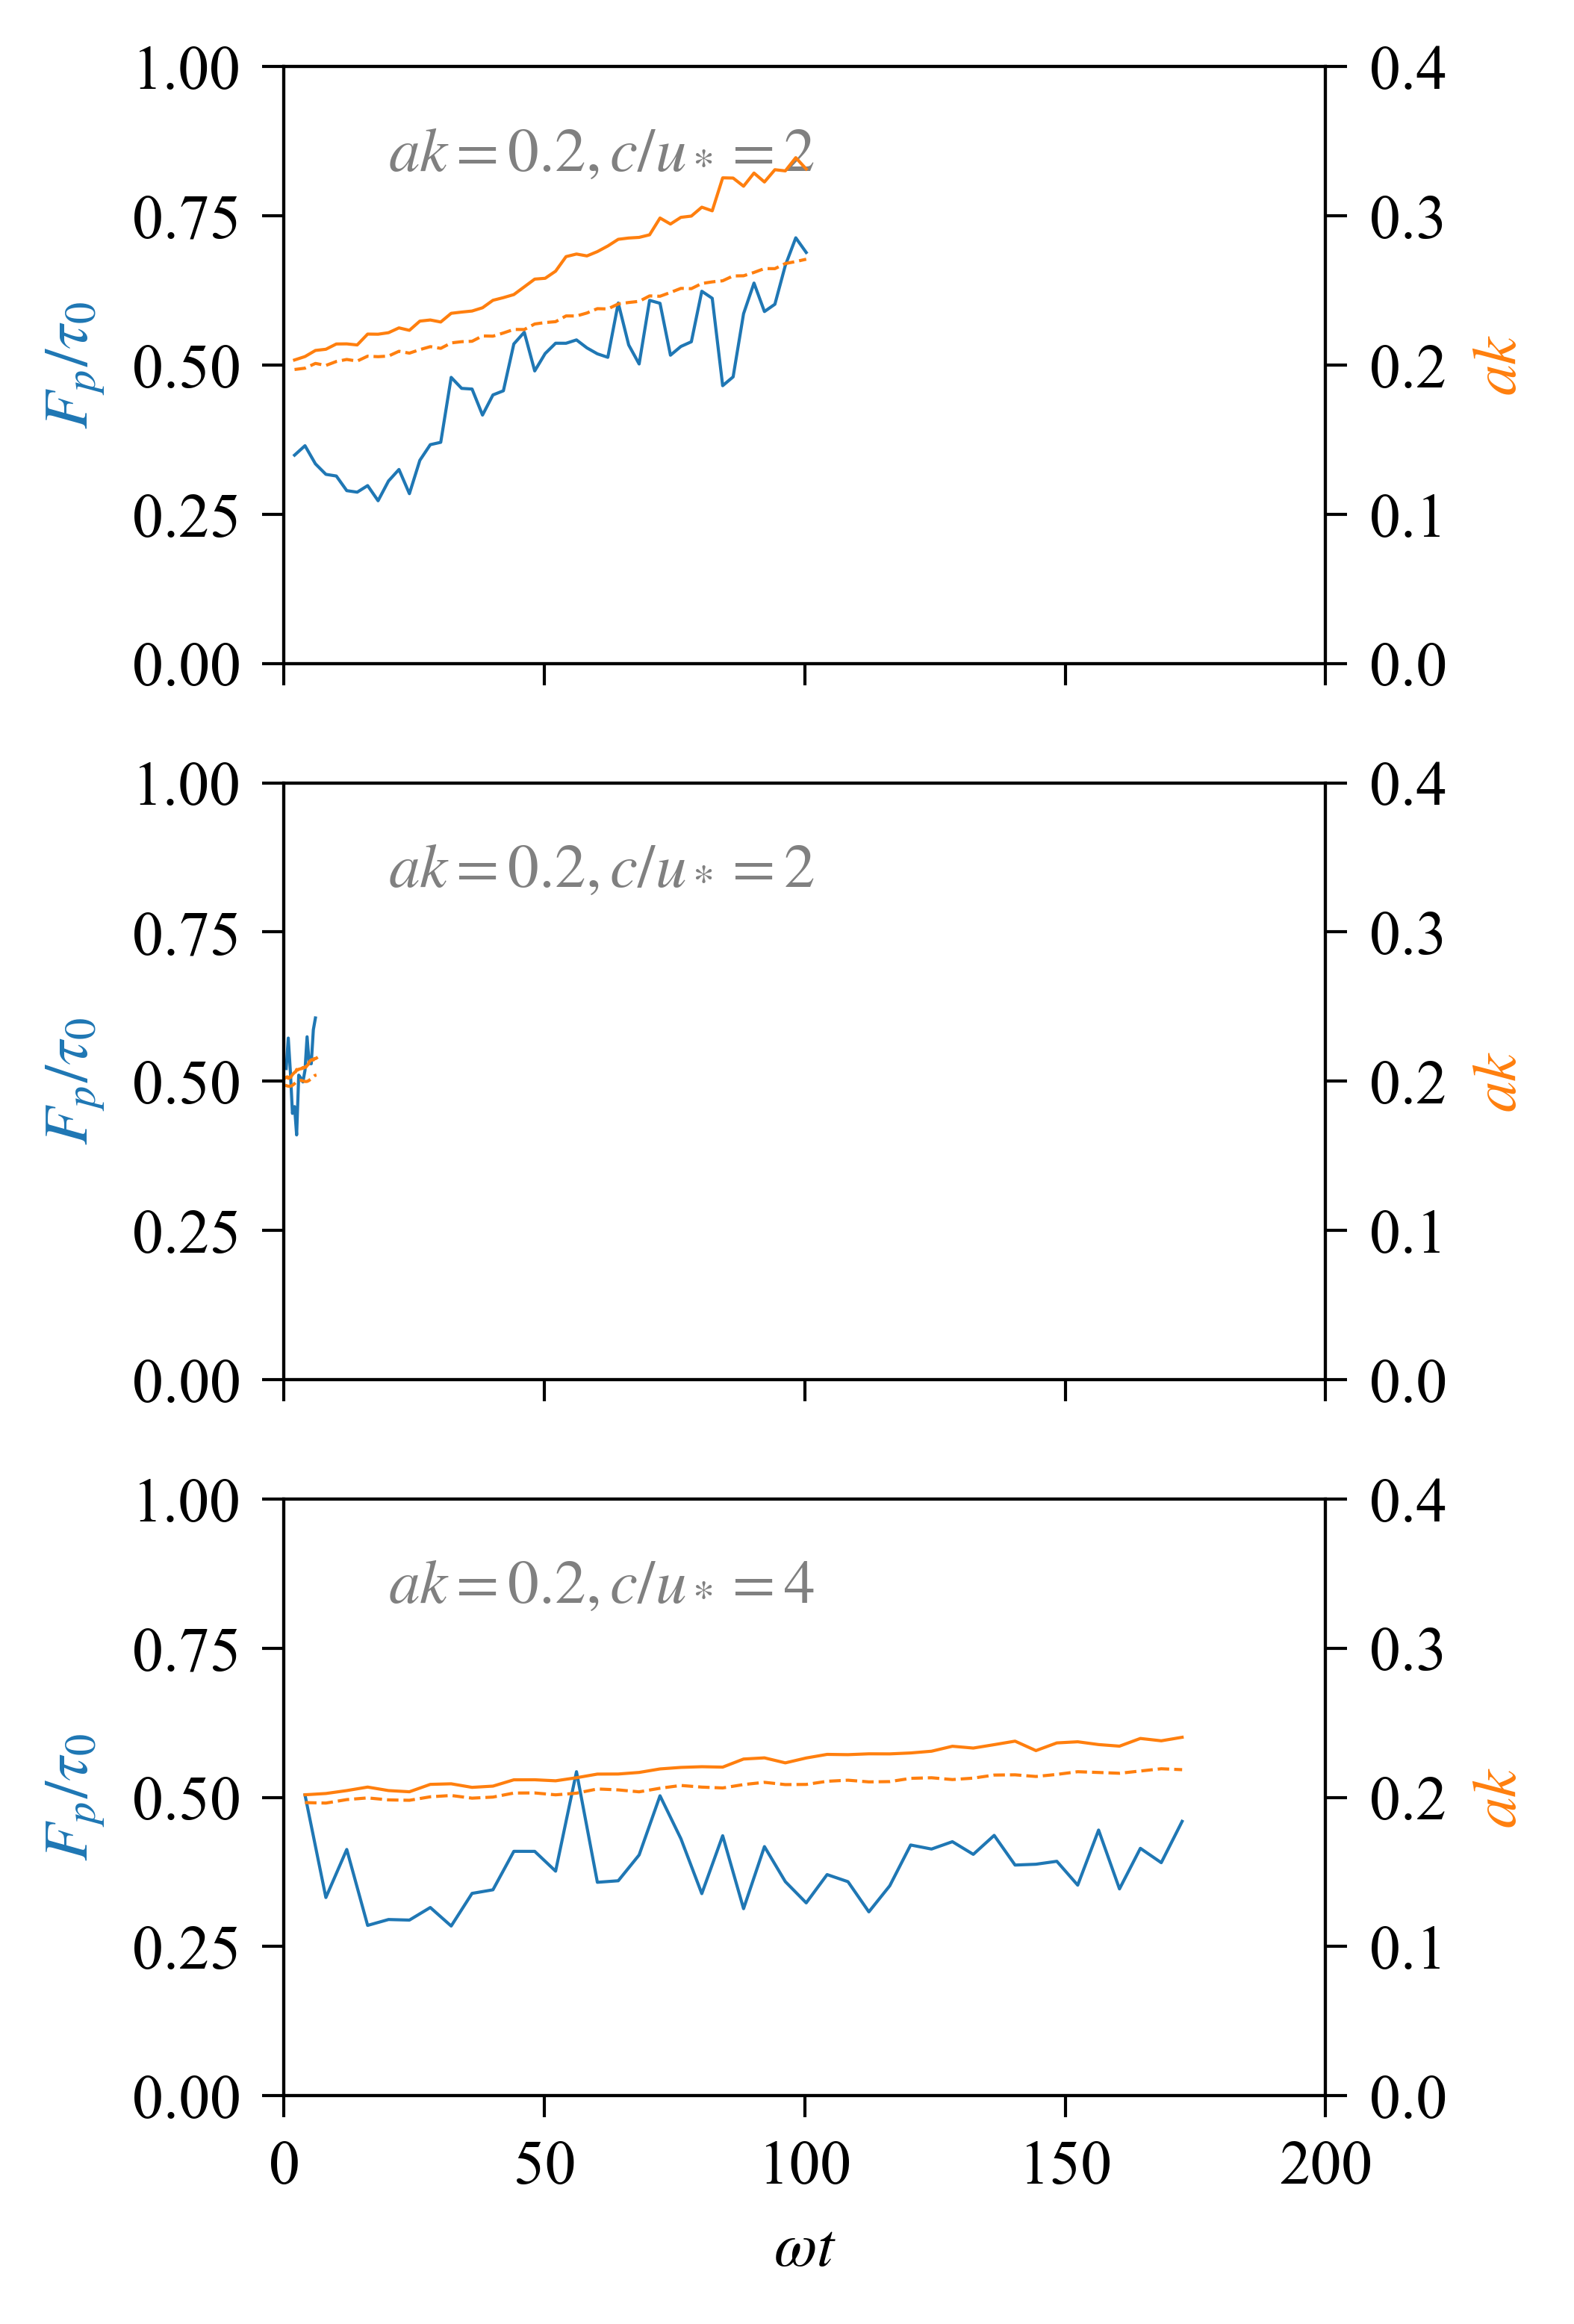

In [50]:
fig, axes = plt.subplots(3,1, sharex='col', figsize=[3,6], gridspec_kw={'height_ratios':[1,1,1], "wspace":0.15, "hspace":0.2})

arms_max = []; arms_min = []
app_max = []; app_min = []
# for (i,case) in enumerate((case1,case2,case3)):
# for (i,case) in enumerate((case7,case9,case11)):
# for (i,case) in enumerate((case4,case5,case6)):
for (i,case) in enumerate((case1,case_rerun_aspect,case2)):
    variance = [np.var(eta) for eta in case.phase['eta']] 
    pp = [(eta.max()-eta.min())/2. for eta in case.phase['eta']] 
    axes[i].plot(np.array(case.p['t'])*case.wave.omega, case.Fp/case.rho2/case.ustar**2, lw=0.5)
    ax1 = axes[i].twinx()
    ax1.plot(np.array(case.phase['t'])*case.wave.omega, np.array(variance)**0.5*1.41*case.k, '--', c='C1', lw=0.5)
    ax1.plot(np.array(case.phase['t'])*case.wave.omega, np.array(pp)*case.k, c='C1', lw=0.5)
    arms_max.append(np.array(variance).max()); arms_min.append(np.array(variance).min())
    app_max.append(np.array(pp).max()); app_min.append(np.array(pp).min())
    axes[i].set_ylim([0., 1])
    ax1.set_ylim([0., 0.4])
    axes[i].set_ylabel(r'$F_p/\tau_0$', c='C0'); ax1.set_ylabel('$ak$', c='C1')
    axes[i].annotate(r'$ak=%g, c/u_*=%.f$' %(case.ak,case.wave.c/case.ustar), xy=(0.1, 0.9), ha='left', va='top', xycoords='axes fraction', c='gray')

axes[2].set_xlabel('$\omega t$')
axes[2].set_xlim([0,200])

In [47]:
def processing_energy_aspect (case):
    case.Fp = np.zeros(len(case.p['p_2D']))
    case.p_1D = np.zeros((len(case.p['p_2D']), 512))
    case.grad = np.zeros((len(case.p['p_2D']), 512))
    for i in tqdm(range(0, len(case.p['p_2D']))):
        # Find time of eta and f
        etai = np.where(np.isclose(case.phase['t'], case.p['t'][i]))[0][0]
        f_2D = case.f_2D[-1]
#         fieldi = np.where(np.isclose(case.field_t, case.p['t'][i]))[0][0]
#         f_2D = case.f_2D[fieldi] # We don't have as big a smapling frequency for f_2D
        """ Subtract the mean """
        case.p['p_2D'][i] = case.p['p_2D'][i]*(1-f_2D)**10 # Air velocity
        bottom = round(case.h/case.L0*case.N) + 8
        paverage = np.average(case.p['p_2D'][i][:,bottom:512])
        case.p['p_2D'][i] = (case.p['p_2D'][i] - paverage)*(1-f_2D)**10
        """ Interpolate onto new coordinate """
        eta = np.roll(np.average(case.phase['eta'][etai], axis=0), -case.phase['idx'][etai], axis=0) - case.h
        p_2D_interp, zgrid = array_newcoord(case.p['p_2D'][i], case=case, eta=eta)
        """ Smooth eta and compute the gradient """
        etahat = savgol_filter(eta, 31, 4) # window size 51, polynomial order 3
        grad = np.gradient(etahat)/(2*np.pi/512)   
#         theta = np.linspace(0,8*np.pi,512)
#         grad = -np.sin(theta)*case.k*(np.var(eta)*2)**0.5
        """ Compute the energy input """
        p = p_2D_interp[:,bottom-2] - np.average(p_2D_interp[:,bottom-2])
        case.p_1D[i] = p
        case.grad[i] = grad
        case.Fp[i] = np.average(p*grad)

In [48]:
processing_energy_aspect(case_rerun_aspect)

100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


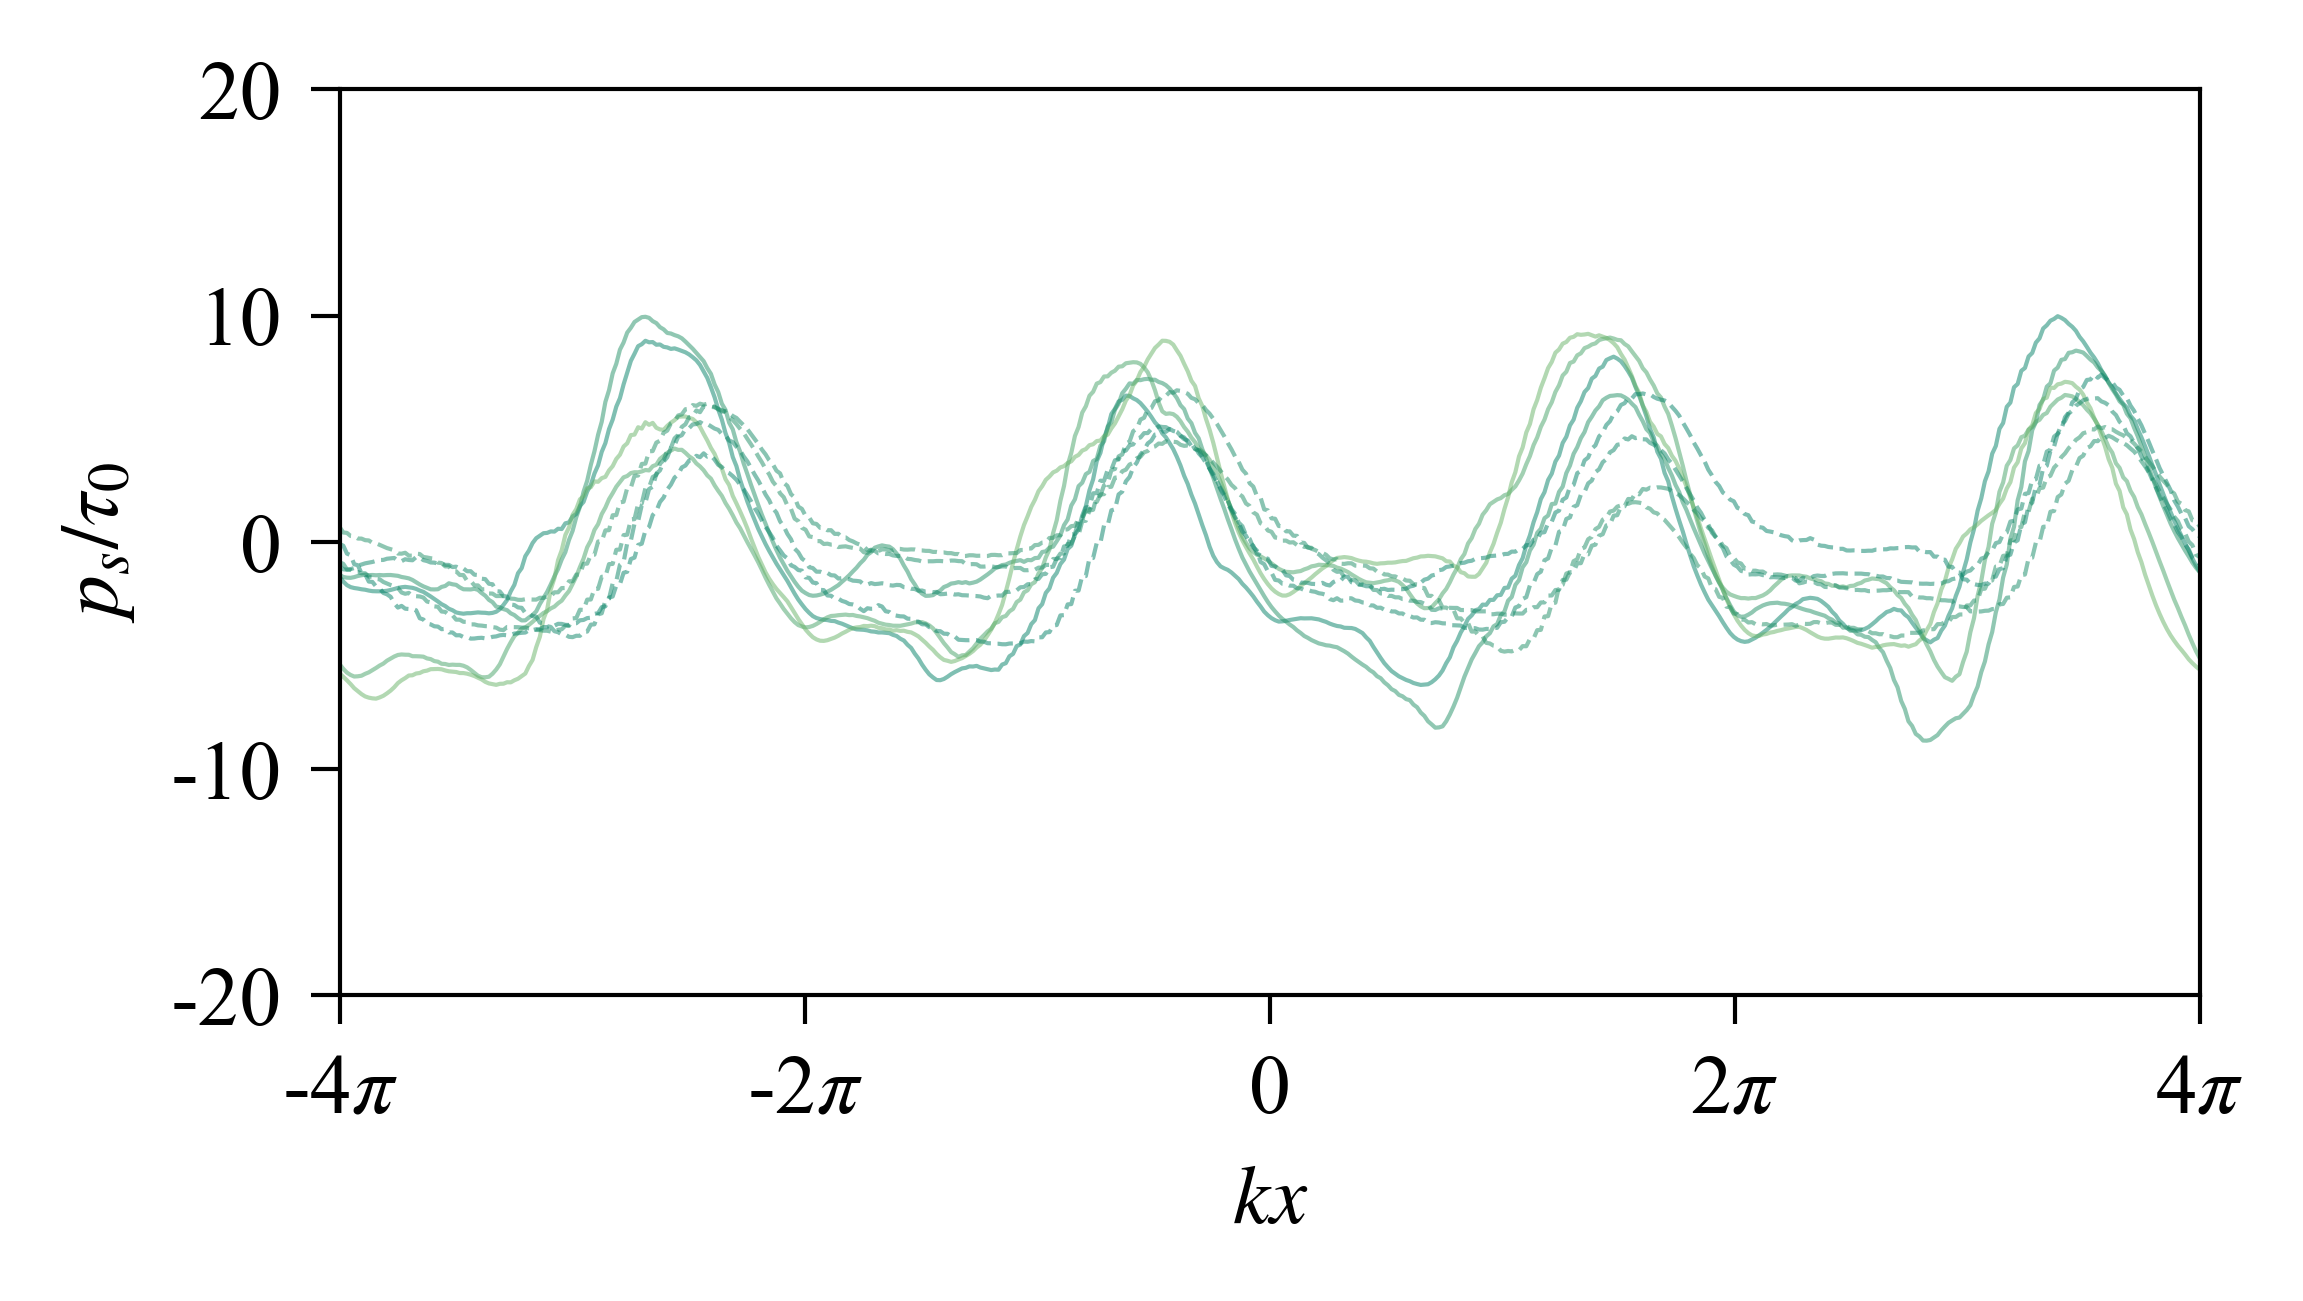

In [53]:
""" Visualization of instantaneous pressure """ 
from matplotlib.ticker import FuncFormatter, MultipleLocator

fig = plt.figure(figsize=[4,2]); ax=plt.gca()
x = np.linspace(-np.pi,np.pi,512)

case = case_rerun_aspect
for j in range(0,8,2):
    plt.plot(x*case.k, case.p_1D[j]/case.rho2/case.ustar**2, c=plt.get_cmap('summer')(j/len(case.p_1D)), lw=0.5, alpha=0.5)
case = case1
for j in range(0,8,2):
    plt.plot(x*case.k, case.p_1D[j]/case.rho2/case.ustar**2, '--', c=plt.get_cmap('summer')(j/len(case.p_1D)), lw=0.5, alpha=0.5)

# for j in np.arange(0, 8, 4):
#     bottom = round(case.h/case.L0*case.N) + 4
#     plt.plot(x*case.k, (case.p['p_2D'][j][:,bottom]-np.average(case.p['p_2D'][j][:,bottom]))/case.rho2/case.ustar**2, c=plt.get_cmap('summer')(j/len(case.p_1D)), lw=0.5, alpha=0.5)
plt.ylim([-20,20])
plt.ylabel(r'$p_s/\tau_0$'); plt.xlabel('$kx$')
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.set_xlim([-4*np.pi,4*np.pi])
ax.set_yticks([-20,-10,0,10,20])
ax.set_xticks([-4*np.pi,-2*np.pi,0,2*np.pi,4*np.pi])
fig.savefig('review/pressure_variation.pdf', bbox_inches='tight')